# Table of Contents

1. [Select Stocks](#select-stocks)
2. [Scrapling](#scrapling)
3. [Yahoo API]()
4. [Selenium](#selenium)
5. [Playwright](#playwright)
6. [Perplexity Results](#perplexity-results-gpt-4o)
   - 3.1 [Prompt](#prompt)
   - 3.2 [Response](#response)
   - 3.3 [Cointegration](#cointegration)
   - 3.4 [Correlation](#correlation)
7. [Cointegration](#cointegration)
8. [News](#news)
9. [Sentiment](#sentiment)
10. [Trade Results](#trade-results)
11. [Overall Summary](#overall-summary)
12. [Breakdown Summary](#breakdown-summary)
13. [Future Works](#future-works)


# POC

Methodology for POC:

1. Choose "AAPL".
2. Scrape news (from Yahoo Finance), for Apple stock via scrapling
3. Use ChatGPT to determine the sentiment of each news on scale of 1 to 5:

- 1 -> Negative
- 2 -> Moderate negative
- 3 -> Neutral
- 4 -> Moderate positive
- 5 -> Positive

4. Use ChatGPT to determine the stock that has highest cointegration with Apple

5. Use Selenium to load more news article


In [1]:
import pandas as pd
import random
import sys
from pathlib import Path
import scrapling
from scrapling import Fetcher
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta, time, date
import yfinance as yf
import numpy as np
from collections import Counter
import math
from pprint import pformat
from decimal import Decimal
from scipy import stats
from typing import Literal, get_args
from zoneinfo import ZoneInfo
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

repo_dir = Path.cwd().as_posix()

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.utils import utils, yahoo_utils, plot_utils
from src.gen_data import GenData
from src.sentiment import SentimentRater
from src.gen_price_action import GenPriceAction
from src.cal_profit_loss import StockTrade
from src.cal_profit_loss import CalProfitLoss
from src.analyze_coint import AnalyzeCoint
from src.plot_news import PlotNews
from src.plot_coint_corr import PlotCointCorr
from src.plot_strategies import PlotStrategies


# [Select Stocks](#table-of-contents)

- Test "AAPL", "NVDA", and "PG" for POC.
- If time permits, then test the randomly selected stocks for each GICS Sector: ['PWR', 'INCY', 'CDW', 'CEG', 'BAC', 'LIN', 'BWA', 'ARE', 'CHTR', 'KDP', 'PSX']


In [33]:
stock_list = utils.gen_stock_list()
stock_list

{'Industrials': 'PWR',
 'Health Care': 'INCY',
 'Information Technology': 'CDW',
 'Utilities': 'CEG',
 'Financials': 'BAC',
 'Materials': 'LIN',
 'Consumer Discretionary': 'BWA',
 'Real Estate': 'ARE',
 'Communication Services': 'CHTR',
 'Consumer Staples': 'KDP',
 'Energy': 'PSX'}

In [36]:
utils.get_gics_sector(
    ["AAPL", "MSFT", "NVDA", "GOOGL", "META", "XOM", "CRM", "HD", "PG"]
)

{'AAPL': 'Information Technology',
 'MSFT': 'Information Technology',
 'NVDA': 'Information Technology',
 'GOOGL': 'Communication Services',
 'META': 'Communication Services',
 'XOM': 'Energy',
 'CRM': 'Information Technology',
 'HD': 'Consumer Discretionary',
 'PG': 'Consumer Staples'}

# [Scrapling](#table-of-contents)

- https://finance.yahoo.com/quote/AAPL/news/
- Scrapling aren't able to web scrap fully since the news are loaded when user scroll to the end of screen.


In [98]:
# Extract news related to AAPL from Yahoo Finance
news_info = yahoo_utils.extract_news_briefs(
    "https://finance.yahoo.com/quote/AAPL/news/"
)
news_info

[2025-03-08 21:01:29] INFO: Fetched (200) <GET https://finance.yahoo.com/quote/AAPL/news/> (referer: https://www.google.com/search?q=yahoo)


[{'publisher': 'Motley Fool',
  'period': datetime.timedelta(seconds=7200),
  'title': 'Could Apple Be a Millionaire-Maker Stock?',
  'content': 'During its rise to become a dominant tech enterprise, Apple (NASDAQ: AAPL) has certainly made its early investors some serious money. In the past two decades, shares have generated a total return of greater than 18,000%, boosted by the introduction of popular hardware devices and services. Could Apple be a millionaire-maker stock?'},
 {'publisher': 'Insider Monkey',
  'period': datetime.timedelta(seconds=43200),
  'title': 'Apple Inc. (AAPL) Unveils AI-Powered MacBook Air with M4 Chip',
  'content': 'We recently compiled a list of the 10 Hot AI News Updates Analysts are Monitoring. In this article, we are going to take a look at where Apple Inc. (NASDAQ:AAPL) stands against the other AI stocks. According to Goldman Sachs, the AI-powered rally in Chinese equities could boost other markets as well. Consequently, the firm has […]'},
 {'publisher

# [Yahoo API](#table-of-contents)

- Yahoo API gives very detailed news as info but limited to max 10 news article.


In [ ]:
ticker = yf.Ticker("AAPL")
ticker.news

[{'id': 'ee08c516-d812-48ab-9787-b73c34782bf7',
  'content': {'id': 'ee08c516-d812-48ab-9787-b73c34782bf7',
   'contentType': 'STORY',
   'title': "Wall Street's souring view on the US stock market isn't just about the economy — it's about AI too",
   'description': '',
   'summary': "As economic uncertainty has spawned a stock market sell-off, one of investors' favorite trades of the past two years is going through its own rerating of expectations.",
   'pubDate': '2025-03-11T17:44:49Z',
   'displayTime': '2025-03-11T17:44:49Z',
   'isHosted': True,
   'bypassModal': False,
   'previewUrl': None,
   'thumbnail': {'originalUrl': 'https://s.yimg.com/os/creatr-uploaded-images/2025-03/88bc1fd0-fb15-11ef-8dbd-ea4aea580f37',
    'originalWidth': 4500,
    'originalHeight': 3001,
    'caption': '',
    'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/CAOKVOjTmaybJSdSciq_vQ--~B/aD0zMDAxO3c9NDUwMDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2025-03/88bc1fd0-fb1

# [Selenium](#table-of-contents)

- Selenium is not suitable as it occasionally run into ReadTimeoutError causing the code to break. Hence we are not able to perform scrolling to required level.
- Running in Jupyter Notebook causes timeout error due to async operation of Jupyter Notebook.


In [ ]:
url = "https://finance.yahoo.com/quote/AAPL/news/"
scroll_limit = 5

driver = webdriver.Chrome()
driver.get(url)

# Locate <a> tag and navigate to its parent <div>
parent_div = driver.find_elements(By.XPATH, "//div[@class='content yf-82qtw3']")

# parent_div.get_attribute("class")

# # Print the class attribute of the parent <div>
# title_element = parent_div.find_element(By.XPATH, ".//h3[contains(@class, 'yf-82qtw3)]")
# title_element.text

ReadTimeoutError: HTTPConnectionPool(host='localhost', port=37797): Read timed out. (read timeout=120)

# [Playwright](#table-of-contents)

- Able to perform scrolling to extract required number of articles as html content.
- Use BeautifulSoup on the generated html content to extract the relevant HTML tags.


In [ ]:
<div class="content yf-82qtw3"><a class="subtle-link fin-size-small titles noUnderline yf-1xqzjha"
        data-ylk="elm:hdln;elmt:link;itc:0;ct:story;slk:Shareholders%20are%20showing%20signs%20of%20DEI%20fatigue%20as%20activists%20push%20for%20more%20votes;sec:qsp-news;subsec:all;cpos:1;g:a42c9cba-3739-4dae-8402-e5acaa0ad944"
        href="https://finance.yahoo.com/news/shareholders-are-showing-signs-of-dei-fatigue-as-activists-push-for-more-votes-140136546.html"
        aria-label="Shareholders are showing signs of DEI fatigue as activists push for more votes"
        title="Shareholders are showing signs of DEI fatigue as activists push for more votes" data-rapid_p="23"
        data-v9y="1">
        <h3 class="clamp  yf-82qtw3">Shareholders are showing signs of DEI fatigue as activists push for more votes</h3>
        <p class="clamp  yf-82qtw3">Champions and critics of DEI policies are again pushing American companies to either
            bolster or diminish their diversity policies. But so far this year, none of the proposals are garnering
            shareholder support.</p>
    </a>
    <div class="footer yf-82qtw3">
        <div class="publishing yf-1weyqlp">Yahoo Finance <i aria-hidden="true" data-svelte-h="svelte-sg6bkb">•</i> 13
            hours ago</div>
        <div class="taxonomy-links yf-13tszyc"><a data-testid="ticker-container"
                class="ticker x-small hover2 border streaming yf-1fqyif7" aria-label="DE"
                data-ylk="elm:qte;elmt:link;itc:0;sec:qsp-news;slk:DE;subsec:all;cpos:1" href="/quote/DE/" title="DE"
                data-rapid_p="24" data-v9y="1">
                <div class="name yf-1fqyif7"><span class="symbol yf-1fqyif7">DE </span> </div> <fin-streamer
                    class="percentChange yf-1fqyif7" data-symbol="DE" data-field="regularMarketChangePercent"
                    data-trend="txt" data-pricehint="2" data-tstyle="default" active=""><span
                        class="d60f3b00 c4af00a5">+3.48%</span></fin-streamer>
            </a> <a data-testid="ticker-container" class="ticker x-small hover2 border streaming yf-1fqyif7"
                aria-label="COST" data-ylk="elm:qte;elmt:link;itc:0;sec:qsp-news;slk:COST;subsec:all;cpos:1"
                href="/quote/COST/" title="COST" data-rapid_p="25" data-v9y="1">
                <div class="name yf-1fqyif7"><span class="symbol yf-1fqyif7">COST </span> </div> <fin-streamer
                    class="percentChange yf-1fqyif7" data-symbol="COST" data-field="regularMarketChangePercent"
                    data-trend="txt" data-pricehint="2" data-tstyle="default" active=""><span
                        class="d60f3b00 d5882186">-6.07%</span></fin-streamer>
            </a> <a data-testid="ticker-container" class="ticker x-small hover2 border streaming yf-1fqyif7"
                aria-label="AAPL" data-ylk="elm:qte;elmt:link;itc:0;sec:qsp-news;slk:AAPL;subsec:all;cpos:1"
                href="/quote/AAPL/" title="AAPL" data-rapid_p="26" data-v9y="1">
                <div class="name yf-1fqyif7"><span class="symbol yf-1fqyif7">AAPL </span> </div> <fin-streamer
                    class="percentChange yf-1fqyif7" data-symbol="AAPL" data-field="regularMarketChangePercent"
                    data-trend="txt" data-pricehint="2" data-tstyle="default" active=""><span
                        class="d60f3b00 c4af00a5">+1.59%</span></fin-streamer>
            </a> </div>
    </div>
</div>

# [Perplexity Results (GPT-4o)](#table-of-contents)


## [Prompt](#table-of-contents)

The list of dictionaries are attached with the following prompt in Perplexity:

```
You are a stock analysis expert.

I've attached list of dictionaries containing news info specifically:

1. publisher = Source where news are generated
2. period = Amount of time lapsed after news release
3. title = News title
4. content = News content in brief

Each dictionary is supposed to be related to Apple stock.

Your task:
1. Review the 'title' and 'content' keys in each dictionary to access the sentiment related to Apple stock.
2. Use ONLY following rating:

    1 = Negative
    2 = Moderate negative
    3 = Neutral
    4 = Moderate positive
    5 = Positive

3. If the news are not related to a Apple stock, please give a rating of 3.
4. Please review all dictionary items in the attached list and provide the corresponding rating.
5. After reviewing all dictionary items, kindly provide an overall sentiment rating for Apple stock.
```


## [Response](#table-of-contents)

Response from Perplexity (ChatGPT 4-o):

```
Sentiment Ratings for Each News Item
Title: "Could Apple Be a Millionaire-Maker Stock?"
Content: Highlights Apple's historical success and potential for future gains.
Rating: 5 (Positive)

Title: "Apple Inc. (AAPL) Unveils AI-Powered MacBook Air with M4 Chip"
Content: Discusses the launch of an innovative product, indicating progress in AI.
Rating: 5 (Positive)

Title: "Apple (AAPL) Beats Stock Market Upswing: What Investors Need to Know"
Content: Reports a positive trading session for Apple stock.
Rating: 4 (Moderate positive)

Title: "Apple Delays Siri Upgrade Indefinitely as AI Concerns Escalate"
Content: Focuses on delays in Apple's AI projects, raising concerns.
Rating: 2 (Moderate negative)

Title: "Apple Is Pushing Back AI-Driven Siri Features to 2026, Report Says"
Content: Similar to the previous item, emphasizes delays in Siri enhancements.
Rating: 2 (Moderate negative)

Title: "Apple Says Some AI-Powered Enhancements to Siri to Be Delayed"
Content: Mentions delays in Siri updates amid slumping iPhone sales.
Rating: 2 (Moderate negative)

Title: "Sector Update: Tech Stocks Advance Late Afternoon"
Content: General update on tech stocks without specific focus on Apple.
Rating: 3 (Neutral)

Title: "Magnificent Seven Stocks: Nvidia Reverses Higher; Amazon, Meta, Tesla Slide"
Content: Discusses multiple tech stocks, with a brief mention of Apple’s mixed performance in 2025.
Rating: 3 (Neutral)

Title: "Apple says some AI improvements to Siri delayed to 2026"
Content: Reiterates delays in Siri's AI features, consistent with earlier reports.
Rating: 2 (Moderate negative)

Title: "Apple's First Foldable iPhone Could Launch in 2026 With Premium Pricing and AI Features"
Content: Speculates on a high-priced foldable iPhone with advanced features, suggesting innovation but no immediate impact.
Rating: 4 (Moderate positive)

Title: "Apple Inc. (AAPL): Jim Cramer Cautions – ‘I Could See the Stock Going Lower!’"
Content: Warns of potential downside for Apple stock, reflecting negativity.
Rating: 1 (Negative)

Title: "Apple Secures Local Content Certifications in Indonesia but Faces Additional Regulatory Hurdles"
Content: Notes progress in regulatory compliance but highlights challenges ahead.
Rating: 3 (Neutral)

Title: "Is Apple Inc. (AAPL) Among the Best Warren Buffett Stock to Buy Right Now?"
Content: Discusses Apple's position as a strong investment option under Warren Buffett’s philosophy, implying positivity.
Rating: 4 (Moderate positive)

Title: "The Mag 7 Stocks Are No Longer Magnificent. Where the Charts Say They Go Next."
Content: Broad commentary on tech stocks, including Apple, with no clear sentiment focus on Apple itself.
Rating: 3 (Neutral)

Title: "Broadcom Shares Jump as AI Growth Fuels Upbeat Forecast"
Content: Primarily about Broadcom, with indirect relevance to Apple as a client company.
Rating: 3 (Neutral)

Title: "Major Breakthrough: New Certificates Propel Apple iPhone 16 into Indonesia"
Content: Highlights progress in regulatory certification for iPhone sales in Indonesia, indicating positive developments for Apple’s market expansion.
Rating: 4 (Moderate positive)

Title: "In Rotten Market, Top Funds Harvest Apple Stock — And 10 Others"
Content: Indicates institutional confidence in Apple stock despite broader market challenges, reflecting positivity.
Rating: 4 (Moderate positive)

Title: "Apple's iPhone 16 Still on Hold in Indonesia Despite Key Certification Win"
Content: Acknowledges regulatory progress but emphasizes ongoing hurdles for product launch in Indonesia.
Rating: 3 (Neutral)

Title: "Cloud AI Today - Cirrascale Launches Inference Cloud For Scalable AI Integration"
Content: Not related to Apple stock specifically but mentions general AI developments in the industry.
Rating: 3 (Neutral)

Title: "38% of Berkshire Hathaway's Portfolio Is Invested in These 3 Unstoppable Dividend Stocks"
Content: General commentary on Warren Buffett’s portfolio with no specific focus on Apple stock sentiment.
Rating: 3 (Neutral)

Overall Sentiment Rating for Apple Stock
The individual ratings suggest a mix of sentiments:

Positive/Moderate Positive Ratings (5 or 4): 8 items

Neutral Ratings (3): 8 items

Negative/Moderate Negative Ratings (1 or 2): 4 items

The overall sentiment leans toward moderately positive for Apple stock, reflecting optimism tempered by some concerns over delays and market challenges.

Final Overall Sentiment Rating:
4 (Moderate positive)
```


## [Cointegration](#table-of-contents)

ChatGPT is not able to provide the stock with highest cointegration value with Apple stock:

```
The query about which S&P 500 stock has the highest cointegration value with Apple stock cannot be answered directly using the provided search results. Cointegration analysis requires statistical computations based on historical price data of Apple stock and other S&P 500 stocks. This involves time-series analysis to determine the long-term equilibrium relationship between Apple and other stocks.

If you have access to historical price data for Apple and other S&P 500 stocks, you can calculate cointegration values using statistical software or programming languages such as Python or R. The process typically involves:

Collecting Data: Obtain historical price data for Apple (AAPL) and other S&P 500 stocks over a specific period.

Stationarity Testing: Use tests like the Augmented Dickey-Fuller (ADF) test to ensure the time series are stationary.

Cointegration Testing: Apply tests such as the Engle-Granger two-step method or Johansen test to identify stocks with high cointegration values with Apple.

If you provide relevant price data or specify tools available, I can guide you further on how to perform this analysis.
```


## [Correlation](#table-of-contents)

ChatGPT 4-o stated Microsoft has the highest degree of correlation:

```
The stock most correlated with Apple (AAPL) among S&P 500 companies is Microsoft (MSFT). Historically, Apple and Microsoft have shown a high degree of correlation due to their positions as leading technology companies and their exposure to similar market dynamics, such as consumer electronics, cloud computing, and software services.

While specific numerical correlation values for S&P 500 stocks are not provided in the search results, Microsoft is widely recognized as one of Apple’s closest peers in terms of performance trends and market behavior. If you need precise correlation coefficients, you would need to calculate them using historical price data for Apple and other S&P 500 stocks over a specific period. Tools like Python, R, or financial platforms can help generate a correlation matrix for this purpose.
```


# [Compute Cointegration](#table-of-contents)

A number of issues with downloading OHLCV data via yfinance:

1. API misuse happen randomly dispite rate limtting and caching.
2. Inaccurate download of OHLCV data using yf.download(<ticker_list>) e.g.

- ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A'] -> ABBV not downloaded but ABNB downloaded instead.
- ABNB downloaded twice.

As such, we have to resort to downloading individual ticker separately. Note that yfinance do not have OHLCV data for 'CTAS', 'BRK.B' and 'BF.B' tickers; therefore they are under the ignored_list.


In [4]:
co_integrate = CoIntegrate()
co_integrate.run()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


    1) MMM    : 1305



[*********************100%***********************]  1 of 1 completed


    2) AOS    : 1305



[*********************100%***********************]  1 of 1 completed


    3) ABT    : 1305



[*********************100%***********************]  1 of 1 completed


    4) ABBV   : 1305



[*********************100%***********************]  1 of 1 completed


    5) ACN    : 1305



[*********************100%***********************]  1 of 1 completed


    6) ADBE   : 1305



[*********************100%***********************]  1 of 1 completed


    7) AMD    : 1305



[*********************100%***********************]  1 of 1 completed


    8) AES    : 1305



[*********************100%***********************]  1 of 1 completed


    9) AFL    : 1305



[*********************100%***********************]  1 of 1 completed


   10) A      : 1305



[*********************100%***********************]  1 of 1 completed


   11) APD    : 1305



[*********************100%***********************]  1 of 1 completed


   12) ABNB   : 1067



[*********************100%***********************]  1 of 1 completed


   13) AKAM   : 1305



[*********************100%***********************]  1 of 1 completed


   14) ALB    : 1305



[*********************100%***********************]  1 of 1 completed


   15) ARE    : 1305



[*********************100%***********************]  1 of 1 completed


   16) ALGN   : 1305



[*********************100%***********************]  1 of 1 completed


   17) ALLE   : 1305



[*********************100%***********************]  1 of 1 completed


   18) LNT    : 1305



[*********************100%***********************]  1 of 1 completed


   19) ALL    : 1305



[*********************100%***********************]  1 of 1 completed


   20) GOOGL  : 1305



[*********************100%***********************]  1 of 1 completed


   21) GOOG   : 1305



[*********************100%***********************]  1 of 1 completed


   22) MO     : 1305



[*********************100%***********************]  1 of 1 completed


   23) AMZN   : 1305



[*********************100%***********************]  1 of 1 completed


   24) AMCR   : 1305



[*********************100%***********************]  1 of 1 completed


   25) AEE    : 1305



[*********************100%***********************]  1 of 1 completed


   26) AEP    : 1305



[*********************100%***********************]  1 of 1 completed


   27) AXP    : 1305



[*********************100%***********************]  1 of 1 completed


   28) AIG    : 1305



[*********************100%***********************]  1 of 1 completed


   29) AMT    : 1305



[*********************100%***********************]  1 of 1 completed


   30) AWK    : 1305



[*********************100%***********************]  1 of 1 completed


   31) AMP    : 1305



[*********************100%***********************]  1 of 1 completed


   32) AME    : 1305



[*********************100%***********************]  1 of 1 completed


   33) AMGN   : 1305



[*********************100%***********************]  1 of 1 completed


   34) APH    : 1305



[*********************100%***********************]  1 of 1 completed


   35) ADI    : 1305



[*********************100%***********************]  1 of 1 completed


   36) ANSS   : 1305



[*********************100%***********************]  1 of 1 completed


   37) AON    : 1305



[*********************100%***********************]  1 of 1 completed


   38) APA    : 1305



[*********************100%***********************]  1 of 1 completed


   39) APO    : 1305



[*********************100%***********************]  1 of 1 completed


   40) AAPL   : 1305



[*********************100%***********************]  1 of 1 completed


   41) AMAT   : 1305



[*********************100%***********************]  1 of 1 completed


   42) APTV   : 1305



[*********************100%***********************]  1 of 1 completed


   43) ACGL   : 1305



[*********************100%***********************]  1 of 1 completed


   44) ADM    : 1305



[*********************100%***********************]  1 of 1 completed


   45) ANET   : 1305



[*********************100%***********************]  1 of 1 completed


   46) AJG    : 1305



[*********************100%***********************]  1 of 1 completed


   47) AIZ    : 1305



[*********************100%***********************]  1 of 1 completed


   48) T      : 1305



[*********************100%***********************]  1 of 1 completed


   49) ATO    : 1305



[*********************100%***********************]  1 of 1 completed


   50) ADSK   : 1305



[*********************100%***********************]  1 of 1 completed


   51) ADP    : 1305



[*********************100%***********************]  1 of 1 completed


   52) AZO    : 1305



[*********************100%***********************]  1 of 1 completed


   53) AVB    : 1305



[*********************100%***********************]  1 of 1 completed


   54) AVY    : 1305



[*********************100%***********************]  1 of 1 completed


   55) AXON   : 1305



[*********************100%***********************]  1 of 1 completed


   56) BKR    : 1305



[*********************100%***********************]  1 of 1 completed


   57) BALL   : 1305



[*********************100%***********************]  1 of 1 completed


   58) BAC    : 1305



[*********************100%***********************]  1 of 1 completed


   59) BAX    : 1305



[*********************100%***********************]  1 of 1 completed


   60) BDX    : 1305



[*********************100%***********************]  1 of 1 completed


   61) BBY    : 1305



[*********************100%***********************]  1 of 1 completed


   62) TECH   : 1305



[*********************100%***********************]  1 of 1 completed


   63) BIIB   : 1305



[*********************100%***********************]  1 of 1 completed


   64) BLK    : 1305



[*********************100%***********************]  1 of 1 completed


   65) BX     : 1305



[*********************100%***********************]  1 of 1 completed


   66) BK     : 1305



[*********************100%***********************]  1 of 1 completed


   67) BA     : 1305



[*********************100%***********************]  1 of 1 completed


   68) BKNG   : 1305



[*********************100%***********************]  1 of 1 completed


   69) BWA    : 1305



[*********************100%***********************]  1 of 1 completed


   70) BSX    : 1305



[*********************100%***********************]  1 of 1 completed


   71) BMY    : 1305



[*********************100%***********************]  1 of 1 completed


   72) AVGO   : 1305



[*********************100%***********************]  1 of 1 completed


   73) BR     : 1305



[*********************100%***********************]  1 of 1 completed


   74) BRO    : 1305



[*********************100%***********************]  1 of 1 completed


   75) BLDR   : 1305



[*********************100%***********************]  1 of 1 completed


   76) BG     : 1305



[*********************100%***********************]  1 of 1 completed


   77) BXP    : 1305



[*********************100%***********************]  1 of 1 completed


   78) CHRW   : 1305



[*********************100%***********************]  1 of 1 completed


   79) CDNS   : 1305



[*********************100%***********************]  1 of 1 completed


   80) CZR    : 1305



[*********************100%***********************]  1 of 1 completed


   81) CPT    : 1305



[*********************100%***********************]  1 of 1 completed


   82) CPB    : 1305



[*********************100%***********************]  1 of 1 completed


   83) COF    : 1305



[*********************100%***********************]  1 of 1 completed


   84) CAH    : 1305



[*********************100%***********************]  1 of 1 completed


   85) KMX    : 1305



[*********************100%***********************]  1 of 1 completed


   86) CCL    : 1305



[*********************100%***********************]  1 of 1 completed


   87) CARR   : 1252



[*********************100%***********************]  1 of 1 completed


   88) CAT    : 1305



[*********************100%***********************]  1 of 1 completed


   89) CBOE   : 1305



[*********************100%***********************]  1 of 1 completed


   90) CBRE   : 1305



[*********************100%***********************]  1 of 1 completed


   91) CDW    : 1305



[*********************100%***********************]  1 of 1 completed


   92) CE     : 1305



[*********************100%***********************]  1 of 1 completed


   93) COR    : 1305



[*********************100%***********************]  1 of 1 completed


   94) CNC    : 1305



[*********************100%***********************]  1 of 1 completed


   95) CNP    : 1305



[*********************100%***********************]  1 of 1 completed


   96) CF     : 1305



[*********************100%***********************]  1 of 1 completed


   97) CRL    : 1305



[*********************100%***********************]  1 of 1 completed


   98) SCHW   : 1305



[*********************100%***********************]  1 of 1 completed


   99) CHTR   : 1305



[*********************100%***********************]  1 of 1 completed


  100) CVX    : 1305



[*********************100%***********************]  1 of 1 completed


  101) CMG    : 1305



[*********************100%***********************]  1 of 1 completed


  102) CB     : 1305



[*********************100%***********************]  1 of 1 completed


  103) CHD    : 1305



[*********************100%***********************]  1 of 1 completed


  104) CI     : 1305



[*********************100%***********************]  1 of 1 completed


  105) CINF   : 1305



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CTAS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2025-03-13)')


  106) CTAS   : 0



[*********************100%***********************]  1 of 1 completed


  107) CSCO   : 1305



[*********************100%***********************]  1 of 1 completed


  108) C      : 1305



[*********************100%***********************]  1 of 1 completed


  109) CFG    : 1305



[*********************100%***********************]  1 of 1 completed


  110) CLX    : 1305



[*********************100%***********************]  1 of 1 completed


  111) CME    : 1305



[*********************100%***********************]  1 of 1 completed


  112) CMS    : 1305



[*********************100%***********************]  1 of 1 completed


  113) KO     : 1305



[*********************100%***********************]  1 of 1 completed


  114) CTSH   : 1305



[*********************100%***********************]  1 of 1 completed


  115) CL     : 1305



[*********************100%***********************]  1 of 1 completed


  116) CMCSA  : 1305



[*********************100%***********************]  1 of 1 completed


  117) CAG    : 1305



[*********************100%***********************]  1 of 1 completed


  118) COP    : 1305



[*********************100%***********************]  1 of 1 completed


  119) ED     : 1305



[*********************100%***********************]  1 of 1 completed


  120) STZ    : 1305



[*********************100%***********************]  1 of 1 completed


  121) CEG    : 789



[*********************100%***********************]  1 of 1 completed


  122) COO    : 1305



[*********************100%***********************]  1 of 1 completed


  123) CPRT   : 1305



[*********************100%***********************]  1 of 1 completed


  124) GLW    : 1305



[*********************100%***********************]  1 of 1 completed


  125) CPAY   : 1305



[*********************100%***********************]  1 of 1 completed


  126) CTVA   : 1305



[*********************100%***********************]  1 of 1 completed


  127) CSGP   : 1305



[*********************100%***********************]  1 of 1 completed


  128) COST   : 1305



[*********************100%***********************]  1 of 1 completed


  129) CTRA   : 1305



[*********************100%***********************]  1 of 1 completed


  130) CRWD   : 1305



[*********************100%***********************]  1 of 1 completed


  131) CCI    : 1305



[*********************100%***********************]  1 of 1 completed


  132) CSX    : 1305



[*********************100%***********************]  1 of 1 completed


  133) CMI    : 1305



[*********************100%***********************]  1 of 1 completed


  134) CVS    : 1305



[*********************100%***********************]  1 of 1 completed


  135) DHR    : 1305



[*********************100%***********************]  1 of 1 completed


  136) DRI    : 1305



[*********************100%***********************]  1 of 1 completed


  137) DVA    : 1305



[*********************100%***********************]  1 of 1 completed


  138) DAY    : 1305



[*********************100%***********************]  1 of 1 completed


  139) DECK   : 1305



[*********************100%***********************]  1 of 1 completed


  140) DE     : 1305



[*********************100%***********************]  1 of 1 completed


  141) DELL   : 1305



[*********************100%***********************]  1 of 1 completed


  142) DAL    : 1305



[*********************100%***********************]  1 of 1 completed


  143) DVN    : 1305



[*********************100%***********************]  1 of 1 completed


  144) DXCM   : 1305



[*********************100%***********************]  1 of 1 completed


  145) FANG   : 1305



[*********************100%***********************]  1 of 1 completed


  146) DLR    : 1305



[*********************100%***********************]  1 of 1 completed


  147) DFS    : 1305



[*********************100%***********************]  1 of 1 completed


  148) DG     : 1305



[*********************100%***********************]  1 of 1 completed


  149) DLTR   : 1305



[*********************100%***********************]  1 of 1 completed


  150) D      : 1305



[*********************100%***********************]  1 of 1 completed


  151) DPZ    : 1305



[*********************100%***********************]  1 of 1 completed


  152) DOV    : 1305



[*********************100%***********************]  1 of 1 completed


  153) DOW    : 1305



[*********************100%***********************]  1 of 1 completed


  154) DHI    : 1305



[*********************100%***********************]  1 of 1 completed


  155) DTE    : 1305



[*********************100%***********************]  1 of 1 completed


  156) DUK    : 1305



[*********************100%***********************]  1 of 1 completed


  157) DD     : 1305



[*********************100%***********************]  1 of 1 completed


  158) EMN    : 1305



[*********************100%***********************]  1 of 1 completed


  159) ETN    : 1305



[*********************100%***********************]  1 of 1 completed


  160) EBAY   : 1305



[*********************100%***********************]  1 of 1 completed


  161) ECL    : 1305



[*********************100%***********************]  1 of 1 completed


  162) EIX    : 1305



[*********************100%***********************]  1 of 1 completed


  163) EW     : 1305



[*********************100%***********************]  1 of 1 completed


  164) EA     : 1305



[*********************100%***********************]  1 of 1 completed


  165) ELV    : 1305



[*********************100%***********************]  1 of 1 completed


  166) EMR    : 1305



[*********************100%***********************]  1 of 1 completed


  167) ENPH   : 1305



[*********************100%***********************]  1 of 1 completed


  168) ETR    : 1305



[*********************100%***********************]  1 of 1 completed


  169) EOG    : 1305



[*********************100%***********************]  1 of 1 completed


  170) EPAM   : 1305



[*********************100%***********************]  1 of 1 completed


  171) EQT    : 1305



[*********************100%***********************]  1 of 1 completed


  172) EFX    : 1305



[*********************100%***********************]  1 of 1 completed


  173) EQIX   : 1305



[*********************100%***********************]  1 of 1 completed


  174) EQR    : 1305



[*********************100%***********************]  1 of 1 completed


  175) ERIE   : 1305



[*********************100%***********************]  1 of 1 completed


  176) ESS    : 1305



[*********************100%***********************]  1 of 1 completed


  177) EL     : 1305



[*********************100%***********************]  1 of 1 completed


  178) EG     : 1305



[*********************100%***********************]  1 of 1 completed


  179) EVRG   : 1305



[*********************100%***********************]  1 of 1 completed


  180) ES     : 1305



[*********************100%***********************]  1 of 1 completed


  181) EXC    : 1305



[*********************100%***********************]  1 of 1 completed


  182) EXPE   : 1305



[*********************100%***********************]  1 of 1 completed


  183) EXPD   : 1305



[*********************100%***********************]  1 of 1 completed


  184) EXR    : 1305



[*********************100%***********************]  1 of 1 completed


  185) XOM    : 1305



[*********************100%***********************]  1 of 1 completed


  186) FFIV   : 1305



[*********************100%***********************]  1 of 1 completed


  187) FDS    : 1305



[*********************100%***********************]  1 of 1 completed


  188) FICO   : 1305



[*********************100%***********************]  1 of 1 completed


  189) FAST   : 1305



[*********************100%***********************]  1 of 1 completed


  190) FRT    : 1305



[*********************100%***********************]  1 of 1 completed


  191) FDX    : 1305



[*********************100%***********************]  1 of 1 completed


  192) FIS    : 1305



[*********************100%***********************]  1 of 1 completed


  193) FITB   : 1305



[*********************100%***********************]  1 of 1 completed


  194) FSLR   : 1305



[*********************100%***********************]  1 of 1 completed


  195) FE     : 1305



[*********************100%***********************]  1 of 1 completed


  196) FI     : 1305



[*********************100%***********************]  1 of 1 completed


  197) FMC    : 1305



[*********************100%***********************]  1 of 1 completed


  198) F      : 1305



[*********************100%***********************]  1 of 1 completed


  199) FTNT   : 1305



[*********************100%***********************]  1 of 1 completed


  200) FTV    : 1305



[*********************100%***********************]  1 of 1 completed


  201) FOXA   : 1305



[*********************100%***********************]  1 of 1 completed


  202) FOX    : 1305



[*********************100%***********************]  1 of 1 completed


  203) BEN    : 1305



[*********************100%***********************]  1 of 1 completed


  204) FCX    : 1305



[*********************100%***********************]  1 of 1 completed


  205) GRMN   : 1305



[*********************100%***********************]  1 of 1 completed


  206) IT     : 1305



[*********************100%***********************]  1 of 1 completed


  207) GE     : 1305



[*********************100%***********************]  1 of 1 completed


  208) GEHC   : 560



[*********************100%***********************]  1 of 1 completed


  209) GEV    : 238



[*********************100%***********************]  1 of 1 completed


  210) GEN    : 1305



[*********************100%***********************]  1 of 1 completed


  211) GNRC   : 1305



[*********************100%***********************]  1 of 1 completed


  212) GD     : 1305



[*********************100%***********************]  1 of 1 completed


  213) GIS    : 1305



[*********************100%***********************]  1 of 1 completed


  214) GM     : 1305



[*********************100%***********************]  1 of 1 completed


  215) GPC    : 1305



[*********************100%***********************]  1 of 1 completed


  216) GILD   : 1305



[*********************100%***********************]  1 of 1 completed


  217) GPN    : 1305



[*********************100%***********************]  1 of 1 completed


  218) GL     : 1305



[*********************100%***********************]  1 of 1 completed


  219) GDDY   : 1305



[*********************100%***********************]  1 of 1 completed


  220) GS     : 1305



[*********************100%***********************]  1 of 1 completed


  221) HAL    : 1305



[*********************100%***********************]  1 of 1 completed


  222) HIG    : 1305



[*********************100%***********************]  1 of 1 completed


  223) HAS    : 1305



[*********************100%***********************]  1 of 1 completed


  224) HCA    : 1305



[*********************100%***********************]  1 of 1 completed


  225) DOC    : 1305



[*********************100%***********************]  1 of 1 completed


  226) HSIC   : 1305



[*********************100%***********************]  1 of 1 completed


  227) HSY    : 1305



[*********************100%***********************]  1 of 1 completed


  228) HES    : 1305



[*********************100%***********************]  1 of 1 completed


  229) HPE    : 1305



[*********************100%***********************]  1 of 1 completed


  230) HLT    : 1305



[*********************100%***********************]  1 of 1 completed


  231) HOLX   : 1305



[*********************100%***********************]  1 of 1 completed


  232) HD     : 1305



[*********************100%***********************]  1 of 1 completed


  233) HON    : 1305



[*********************100%***********************]  1 of 1 completed


  234) HRL    : 1305



[*********************100%***********************]  1 of 1 completed


  235) HST    : 1305



[*********************100%***********************]  1 of 1 completed


  236) HWM    : 1305



[*********************100%***********************]  1 of 1 completed


  237) HPQ    : 1305



[*********************100%***********************]  1 of 1 completed


  238) HUBB   : 1305



[*********************100%***********************]  1 of 1 completed


  239) HUM    : 1305



[*********************100%***********************]  1 of 1 completed


  240) HBAN   : 1305



[*********************100%***********************]  1 of 1 completed


  241) HII    : 1305



[*********************100%***********************]  1 of 1 completed


  242) IBM    : 1305



[*********************100%***********************]  1 of 1 completed


  243) IEX    : 1305



[*********************100%***********************]  1 of 1 completed


  244) IDXX   : 1305



[*********************100%***********************]  1 of 1 completed


  245) ITW    : 1305



[*********************100%***********************]  1 of 1 completed


  246) INCY   : 1305



[*********************100%***********************]  1 of 1 completed


  247) IR     : 1305



[*********************100%***********************]  1 of 1 completed


  248) PODD   : 1305



[*********************100%***********************]  1 of 1 completed


  249) INTC   : 1305



[*********************100%***********************]  1 of 1 completed


  250) ICE    : 1305



[*********************100%***********************]  1 of 1 completed


  251) IFF    : 1305



[*********************100%***********************]  1 of 1 completed


  252) IP     : 1305



[*********************100%***********************]  1 of 1 completed


  253) IPG    : 1305



[*********************100%***********************]  1 of 1 completed


  254) INTU   : 1305



[*********************100%***********************]  1 of 1 completed


  255) ISRG   : 1305



[*********************100%***********************]  1 of 1 completed


  256) IVZ    : 1305



[*********************100%***********************]  1 of 1 completed


  257) INVH   : 1305



[*********************100%***********************]  1 of 1 completed


  258) IQV    : 1305



[*********************100%***********************]  1 of 1 completed


  259) IRM    : 1305



[*********************100%***********************]  1 of 1 completed


  260) JBHT   : 1305



[*********************100%***********************]  1 of 1 completed


  261) JBL    : 1305



[*********************100%***********************]  1 of 1 completed


  262) JKHY   : 1305



[*********************100%***********************]  1 of 1 completed


  263) J      : 1305



[*********************100%***********************]  1 of 1 completed


  264) JNJ    : 1305



[*********************100%***********************]  1 of 1 completed


  265) JCI    : 1305



[*********************100%***********************]  1 of 1 completed


  266) JPM    : 1305



[*********************100%***********************]  1 of 1 completed


  267) JNPR   : 1305



[*********************100%***********************]  1 of 1 completed


  268) K      : 1305



[*********************100%***********************]  1 of 1 completed


  269) KVUE   : 465



[*********************100%***********************]  1 of 1 completed


  270) KDP    : 1305



[*********************100%***********************]  1 of 1 completed


  271) KEY    : 1305



[*********************100%***********************]  1 of 1 completed


  272) KEYS   : 1305



[*********************100%***********************]  1 of 1 completed


  273) KMB    : 1305



[*********************100%***********************]  1 of 1 completed


  274) KIM    : 1305



[*********************100%***********************]  1 of 1 completed


  275) KMI    : 1305



[*********************100%***********************]  1 of 1 completed


  276) KKR    : 1305



[*********************100%***********************]  1 of 1 completed


  277) KLAC   : 1305



[*********************100%***********************]  1 of 1 completed


  278) KHC    : 1305



[*********************100%***********************]  1 of 1 completed


  279) KR     : 1305



[*********************100%***********************]  1 of 1 completed


  280) LHX    : 1305



[*********************100%***********************]  1 of 1 completed


  281) LH     : 1305



[*********************100%***********************]  1 of 1 completed


  282) LRCX   : 1305



[*********************100%***********************]  1 of 1 completed


  283) LW     : 1305



[*********************100%***********************]  1 of 1 completed


  284) LVS    : 1305



[*********************100%***********************]  1 of 1 completed


  285) LDOS   : 1305



[*********************100%***********************]  1 of 1 completed


  286) LEN    : 1305



[*********************100%***********************]  1 of 1 completed


  287) LII    : 1305



[*********************100%***********************]  1 of 1 completed


  288) LLY    : 1305



[*********************100%***********************]  1 of 1 completed


  289) LIN    : 1305



[*********************100%***********************]  1 of 1 completed


  290) LYV    : 1305



[*********************100%***********************]  1 of 1 completed


  291) LKQ    : 1305



[*********************100%***********************]  1 of 1 completed


  292) LMT    : 1305



[*********************100%***********************]  1 of 1 completed


  293) L      : 1305



[*********************100%***********************]  1 of 1 completed


  294) LOW    : 1305



[*********************100%***********************]  1 of 1 completed


  295) LULU   : 1305



[*********************100%***********************]  1 of 1 completed


  296) LYB    : 1305



[*********************100%***********************]  1 of 1 completed


  297) MTB    : 1305



[*********************100%***********************]  1 of 1 completed


  298) MPC    : 1305



[*********************100%***********************]  1 of 1 completed


  299) MKTX   : 1305



[*********************100%***********************]  1 of 1 completed


  300) MAR    : 1305



[*********************100%***********************]  1 of 1 completed


  301) MMC    : 1305



[*********************100%***********************]  1 of 1 completed


  302) MLM    : 1305



[*********************100%***********************]  1 of 1 completed


  303) MAS    : 1305



[*********************100%***********************]  1 of 1 completed


  304) MA     : 1305



[*********************100%***********************]  1 of 1 completed


  305) MTCH   : 1305



[*********************100%***********************]  1 of 1 completed


  306) MKC    : 1305



[*********************100%***********************]  1 of 1 completed


  307) MCD    : 1305



[*********************100%***********************]  1 of 1 completed


  308) MCK    : 1305



[*********************100%***********************]  1 of 1 completed


  309) MDT    : 1305



[*********************100%***********************]  1 of 1 completed


  310) MRK    : 1305



[*********************100%***********************]  1 of 1 completed


  311) META   : 1305



[*********************100%***********************]  1 of 1 completed


  312) MET    : 1305



[*********************100%***********************]  1 of 1 completed


  313) MTD    : 1305



[*********************100%***********************]  1 of 1 completed


  314) MGM    : 1305



[*********************100%***********************]  1 of 1 completed


  315) MCHP   : 1305



[*********************100%***********************]  1 of 1 completed


  316) MU     : 1305



[*********************100%***********************]  1 of 1 completed


  317) MSFT   : 1305



[*********************100%***********************]  1 of 1 completed


  318) MAA    : 1305



[*********************100%***********************]  1 of 1 completed


  319) MRNA   : 1305



[*********************100%***********************]  1 of 1 completed


  320) MHK    : 1305



[*********************100%***********************]  1 of 1 completed


  321) MOH    : 1305



[*********************100%***********************]  1 of 1 completed


  322) TAP    : 1305



[*********************100%***********************]  1 of 1 completed


  323) MDLZ   : 1305



[*********************100%***********************]  1 of 1 completed


  324) MPWR   : 1305



[*********************100%***********************]  1 of 1 completed


  325) MNST   : 1305



[*********************100%***********************]  1 of 1 completed


  326) MCO    : 1305



[*********************100%***********************]  1 of 1 completed


  327) MS     : 1305



[*********************100%***********************]  1 of 1 completed


  328) MOS    : 1305



[*********************100%***********************]  1 of 1 completed


  329) MSI    : 1305



[*********************100%***********************]  1 of 1 completed


  330) MSCI   : 1305



[*********************100%***********************]  1 of 1 completed


  331) NDAQ   : 1305



[*********************100%***********************]  1 of 1 completed


  332) NTAP   : 1305



[*********************100%***********************]  1 of 1 completed


  333) NFLX   : 1305



[*********************100%***********************]  1 of 1 completed


  334) NEM    : 1305



[*********************100%***********************]  1 of 1 completed


  335) NWSA   : 1305



[*********************100%***********************]  1 of 1 completed


  336) NWS    : 1305



[*********************100%***********************]  1 of 1 completed


  337) NEE    : 1305



[*********************100%***********************]  1 of 1 completed


  338) NKE    : 1305



[*********************100%***********************]  1 of 1 completed


  339) NI     : 1305



[*********************100%***********************]  1 of 1 completed


  340) NDSN   : 1305



[*********************100%***********************]  1 of 1 completed


  341) NSC    : 1305



[*********************100%***********************]  1 of 1 completed


  342) NTRS   : 1305



[*********************100%***********************]  1 of 1 completed


  343) NOC    : 1305



[*********************100%***********************]  1 of 1 completed


  344) NCLH   : 1305



[*********************100%***********************]  1 of 1 completed


  345) NRG    : 1305



[*********************100%***********************]  1 of 1 completed


  346) NUE    : 1305



[*********************100%***********************]  1 of 1 completed


  347) NVDA   : 1305



[*********************100%***********************]  1 of 1 completed


  348) NVR    : 1305



[*********************100%***********************]  1 of 1 completed


  349) NXPI   : 1305



[*********************100%***********************]  1 of 1 completed


  350) ORLY   : 1305



[*********************100%***********************]  1 of 1 completed


  351) OXY    : 1305



[*********************100%***********************]  1 of 1 completed


  352) ODFL   : 1305



[*********************100%***********************]  1 of 1 completed


  353) OMC    : 1305



[*********************100%***********************]  1 of 1 completed


  354) ON     : 1305



[*********************100%***********************]  1 of 1 completed


  355) OKE    : 1305



[*********************100%***********************]  1 of 1 completed


  356) ORCL   : 1305



[*********************100%***********************]  1 of 1 completed


  357) OTIS   : 1252



[*********************100%***********************]  1 of 1 completed


  358) PCAR   : 1305



[*********************100%***********************]  1 of 1 completed


  359) PKG    : 1305



[*********************100%***********************]  1 of 1 completed


  360) PLTR   : 1117



[*********************100%***********************]  1 of 1 completed


  361) PANW   : 1305



[*********************100%***********************]  1 of 1 completed


  362) PARA   : 1305



[*********************100%***********************]  1 of 1 completed


  363) PH     : 1305



[*********************100%***********************]  1 of 1 completed


  364) PAYX   : 1305



[*********************100%***********************]  1 of 1 completed


  365) PAYC   : 1305



[*********************100%***********************]  1 of 1 completed


  366) PYPL   : 1305



[*********************100%***********************]  1 of 1 completed


  367) PNR    : 1305



[*********************100%***********************]  1 of 1 completed


  368) PEP    : 1305



[*********************100%***********************]  1 of 1 completed


  369) PFE    : 1305



[*********************100%***********************]  1 of 1 completed


  370) PCG    : 1305



[*********************100%***********************]  1 of 1 completed


  371) PM     : 1305



[*********************100%***********************]  1 of 1 completed


  372) PSX    : 1305



[*********************100%***********************]  1 of 1 completed


  373) PNW    : 1305



[*********************100%***********************]  1 of 1 completed


  374) PNC    : 1305



[*********************100%***********************]  1 of 1 completed


  375) POOL   : 1305



[*********************100%***********************]  1 of 1 completed


  376) PPG    : 1305



[*********************100%***********************]  1 of 1 completed


  377) PPL    : 1305



[*********************100%***********************]  1 of 1 completed


  378) PFG    : 1305



[*********************100%***********************]  1 of 1 completed


  379) PG     : 1305



[*********************100%***********************]  1 of 1 completed


  380) PGR    : 1305



[*********************100%***********************]  1 of 1 completed


  381) PLD    : 1305



[*********************100%***********************]  1 of 1 completed


  382) PRU    : 1305



[*********************100%***********************]  1 of 1 completed


  383) PEG    : 1305



[*********************100%***********************]  1 of 1 completed


  384) PTC    : 1305



[*********************100%***********************]  1 of 1 completed


  385) PSA    : 1305



[*********************100%***********************]  1 of 1 completed


  386) PHM    : 1305



[*********************100%***********************]  1 of 1 completed


  387) PWR    : 1305



[*********************100%***********************]  1 of 1 completed


  388) QCOM   : 1305



[*********************100%***********************]  1 of 1 completed


  389) DGX    : 1305



[*********************100%***********************]  1 of 1 completed


  390) RL     : 1305



[*********************100%***********************]  1 of 1 completed


  391) RJF    : 1305



[*********************100%***********************]  1 of 1 completed


  392) RTX    : 1305



[*********************100%***********************]  1 of 1 completed


  393) O      : 1305



[*********************100%***********************]  1 of 1 completed


  394) REG    : 1305



[*********************100%***********************]  1 of 1 completed


  395) REGN   : 1305



[*********************100%***********************]  1 of 1 completed


  396) RF     : 1305



[*********************100%***********************]  1 of 1 completed


  397) RSG    : 1305



[*********************100%***********************]  1 of 1 completed


  398) RMD    : 1305



[*********************100%***********************]  1 of 1 completed


  399) RVTY   : 1305



[*********************100%***********************]  1 of 1 completed


  400) ROK    : 1305



[*********************100%***********************]  1 of 1 completed


  401) ROL    : 1305



[*********************100%***********************]  1 of 1 completed


  402) ROP    : 1305



[*********************100%***********************]  1 of 1 completed


  403) ROST   : 1305



[*********************100%***********************]  1 of 1 completed


  404) RCL    : 1305



[*********************100%***********************]  1 of 1 completed


  405) SPGI   : 1305



[*********************100%***********************]  1 of 1 completed


  406) CRM    : 1305



[*********************100%***********************]  1 of 1 completed


  407) SBAC   : 1305



[*********************100%***********************]  1 of 1 completed


  408) SLB    : 1305



[*********************100%***********************]  1 of 1 completed


  409) STX    : 1305



[*********************100%***********************]  1 of 1 completed


  410) SRE    : 1305



[*********************100%***********************]  1 of 1 completed


  411) NOW    : 1305



[*********************100%***********************]  1 of 1 completed


  412) SHW    : 1305



[*********************100%***********************]  1 of 1 completed


  413) SPG    : 1305



[*********************100%***********************]  1 of 1 completed


  414) SWKS   : 1305



[*********************100%***********************]  1 of 1 completed


  415) SJM    : 1305



[*********************100%***********************]  1 of 1 completed


  416) SW     : 171



[*********************100%***********************]  1 of 1 completed


  417) SNA    : 1305



[*********************100%***********************]  1 of 1 completed


  418) SOLV   : 238



[*********************100%***********************]  1 of 1 completed


  419) SO     : 1305



[*********************100%***********************]  1 of 1 completed


  420) LUV    : 1305



[*********************100%***********************]  1 of 1 completed


  421) SWK    : 1305



[*********************100%***********************]  1 of 1 completed


  422) SBUX   : 1305



[*********************100%***********************]  1 of 1 completed


  423) STT    : 1305



[*********************100%***********************]  1 of 1 completed


  424) STLD   : 1305



[*********************100%***********************]  1 of 1 completed


  425) STE    : 1305



[*********************100%***********************]  1 of 1 completed


  426) SYK    : 1305



[*********************100%***********************]  1 of 1 completed


  427) SMCI   : 1305



[*********************100%***********************]  1 of 1 completed


  428) SYF    : 1305



[*********************100%***********************]  1 of 1 completed


  429) SNPS   : 1305



[*********************100%***********************]  1 of 1 completed


  430) SYY    : 1305



[*********************100%***********************]  1 of 1 completed


  431) TMUS   : 1305



[*********************100%***********************]  1 of 1 completed


  432) TROW   : 1305



[*********************100%***********************]  1 of 1 completed


  433) TTWO   : 1305



[*********************100%***********************]  1 of 1 completed


  434) TPR    : 1305



[*********************100%***********************]  1 of 1 completed


  435) TRGP   : 1305



[*********************100%***********************]  1 of 1 completed


  436) TGT    : 1305



[*********************100%***********************]  1 of 1 completed


  437) TEL    : 1305



[*********************100%***********************]  1 of 1 completed


  438) TDY    : 1305



[*********************100%***********************]  1 of 1 completed


  439) TFX    : 1305



[*********************100%***********************]  1 of 1 completed


  440) TER    : 1305



[*********************100%***********************]  1 of 1 completed


  441) TSLA   : 1305



[*********************100%***********************]  1 of 1 completed


  442) TXN    : 1305



[*********************100%***********************]  1 of 1 completed


  443) TPL    : 1305



[*********************100%***********************]  1 of 1 completed


  444) TXT    : 1305



[*********************100%***********************]  1 of 1 completed


  445) TMO    : 1305



[*********************100%***********************]  1 of 1 completed


  446) TJX    : 1305



[*********************100%***********************]  1 of 1 completed


  447) TSCO   : 1305



[*********************100%***********************]  1 of 1 completed


  448) TT     : 1305



[*********************100%***********************]  1 of 1 completed


  449) TDG    : 1305



[*********************100%***********************]  1 of 1 completed


  450) TRV    : 1305



[*********************100%***********************]  1 of 1 completed


  451) TRMB   : 1305



[*********************100%***********************]  1 of 1 completed


  452) TFC    : 1305



[*********************100%***********************]  1 of 1 completed


  453) TYL    : 1305



[*********************100%***********************]  1 of 1 completed


  454) TSN    : 1305



[*********************100%***********************]  1 of 1 completed


  455) USB    : 1305



[*********************100%***********************]  1 of 1 completed


  456) UBER   : 1305



[*********************100%***********************]  1 of 1 completed


  457) UDR    : 1305



[*********************100%***********************]  1 of 1 completed


  458) ULTA   : 1305



[*********************100%***********************]  1 of 1 completed


  459) UNP    : 1305



[*********************100%***********************]  1 of 1 completed


  460) UAL    : 1305



[*********************100%***********************]  1 of 1 completed


  461) UPS    : 1305



[*********************100%***********************]  1 of 1 completed


  462) URI    : 1305



[*********************100%***********************]  1 of 1 completed


  463) UNH    : 1305



[*********************100%***********************]  1 of 1 completed


  464) UHS    : 1305



[*********************100%***********************]  1 of 1 completed


  465) VLO    : 1305



[*********************100%***********************]  1 of 1 completed


  466) VTR    : 1305



[*********************100%***********************]  1 of 1 completed


  467) VLTO   : 360



[*********************100%***********************]  1 of 1 completed


  468) VRSN   : 1305



[*********************100%***********************]  1 of 1 completed


  469) VRSK   : 1305



[*********************100%***********************]  1 of 1 completed


  470) VZ     : 1305



[*********************100%***********************]  1 of 1 completed


  471) VRTX   : 1305



[*********************100%***********************]  1 of 1 completed


  472) VTRS   : 1305



[*********************100%***********************]  1 of 1 completed


  473) VICI   : 1305



[*********************100%***********************]  1 of 1 completed


  474) V      : 1305



[*********************100%***********************]  1 of 1 completed


  475) VST    : 1305



[*********************100%***********************]  1 of 1 completed


  476) VMC    : 1305



[*********************100%***********************]  1 of 1 completed


  477) WRB    : 1305



[*********************100%***********************]  1 of 1 completed


  478) GWW    : 1305



[*********************100%***********************]  1 of 1 completed


  479) WAB    : 1305



[*********************100%***********************]  1 of 1 completed


  480) WBA    : 1305



[*********************100%***********************]  1 of 1 completed


  481) WMT    : 1305



[*********************100%***********************]  1 of 1 completed


  482) DIS    : 1305



[*********************100%***********************]  1 of 1 completed


  483) WBD    : 1305



[*********************100%***********************]  1 of 1 completed


  484) WM     : 1305



[*********************100%***********************]  1 of 1 completed


  485) WAT    : 1305



[*********************100%***********************]  1 of 1 completed


  486) WEC    : 1305



[*********************100%***********************]  1 of 1 completed


  487) WFC    : 1305



[*********************100%***********************]  1 of 1 completed


  488) WELL   : 1305



[*********************100%***********************]  1 of 1 completed


  489) WST    : 1305



[*********************100%***********************]  1 of 1 completed


  490) WDC    : 1305



[*********************100%***********************]  1 of 1 completed


  491) WY     : 1305



[*********************100%***********************]  1 of 1 completed


  492) WMB    : 1305



[*********************100%***********************]  1 of 1 completed


  493) WTW    : 1305



[*********************100%***********************]  1 of 1 completed


  494) WDAY   : 1305



[*********************100%***********************]  1 of 1 completed


  495) WYNN   : 1305



[*********************100%***********************]  1 of 1 completed


  496) XEL    : 1305



[*********************100%***********************]  1 of 1 completed


  497) XYL    : 1305



[*********************100%***********************]  1 of 1 completed


  498) YUM    : 1305



[*********************100%***********************]  1 of 1 completed


  499) ZBRA   : 1305



[*********************100%***********************]  1 of 1 completed


  500) ZBH    : 1305



[*********************100%***********************]  1 of 1 completed

  501) ZTS    : 1305



In [ ]:
# 'CTAS' OHLCV dta is not available in yfinance
yf.download("CTAS", start="2020-01-01")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CTAS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2025-03-13)')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,CTAS,CTAS,CTAS,CTAS,CTAS,CTAS
Date,,,,,,


## [1 Year Period](#table-of-contents)


In [ ]:
df_1y = pd.read_csv("./data/coint_corr/2025-03-28/coint_corr_1y.csv")
df_1y

,ticker1,ticker2,coint,pearsonr,spearmanr,kendalltau
0,MMM,AOS,0.318636,-0.739837,-0.674401,-0.504392
1,MMM,ABT,0.037253,0.844638,0.841827,0.605854
2,MMM,ABBV,0.247177,0.795093,0.763711,0.565531
3,MMM,ACN,0.701204,0.713788,0.675311,0.486818
4,MMM,ADBE,0.603408,-0.332484,-0.339570,-0.217770
...,...,...,...,...,...,...
123251,YUM,ZBH,0.958000,-0.032467,0.140320,0.094599
123252,YUM,ZTS,0.864792,-0.295493,-0.281127,-0.178846
123253,ZBRA,ZBH,0.481884,-0.410229,-0.326750,-0.203995
123254,ZBRA,ZTS,0.847695,0.377118,0.407230,0.289736


In [ ]:
df_1y.describe()

,coint,pearsonr,spearmanr,kendalltau
count,1.232560e+05,123256.000000,123256.000000,123256.000000
mean,4.922691e-01,0.156011,0.163778,0.128605
std,2.887560e-01,0.512292,0.497596,0.354407
min,8.133446e-12,-0.966227,-0.961209,-0.821937
25%,2.404698e-01,-0.261061,-0.234240,-0.140983
50%,4.967837e-01,0.218805,0.218946,0.153262
75%,7.400212e-01,0.604779,0.600842,0.415093
max,1.000000e+00,0.999772,0.999607,0.987073


## [3 years period](#table-of-contents)


In [42]:
df_3y = pd.read_csv("./data/coint_corr/2025-03-28/coint_corr_3y.csv")
df_3y

,ticker1,ticker2,coint,pearsonr,spearmanr,kendalltau
0,MMM,AOS,0.981175,0.119572,0.062192,0.047506
1,MMM,ABT,0.227779,0.750963,0.607554,0.452330
2,MMM,ABBV,0.445999,0.732515,0.530343,0.374159
3,MMM,ACN,0.979434,0.478753,0.315829,0.244487
4,MMM,ADBE,0.982354,-0.013198,-0.103160,-0.042506
...,...,...,...,...,...,...
121766,YUM,ZBH,0.939087,0.147743,0.137775,0.107958
121767,YUM,ZTS,0.934539,0.324943,0.353749,0.233717
121768,ZBRA,ZBH,0.156284,-0.172128,-0.196864,-0.120074
121769,ZBRA,ZTS,0.292152,0.238098,0.184189,0.156022


In [43]:
df_3y.describe()

,coint,pearsonr,spearmanr,kendalltau
count,1.217710e+05,121771.000000,121771.000000,121771.000000
mean,4.263158e-01,0.284084,0.276464,0.212278
std,3.112215e-01,0.489068,0.473779,0.346119
min,6.955269e-07,-0.958737,-0.947694,-0.788410
25%,1.423161e-01,-0.079776,-0.063995,-0.031042
50%,3.765642e-01,0.369986,0.349094,0.241347
75%,6.967812e-01,0.714118,0.684369,0.491048
max,1.000000e+00,0.999945,0.999922,0.993944


## [5 years period](#table-of-contents)


In [44]:
df_5y = pd.read_csv("./data/coint_corr/2025-03-28/coint_corr_5y.csv")
df_5y

,ticker1,ticker2,coint,pearsonr,spearmanr,kendalltau
0,MMM,AOS,0.924690,-0.002716,-0.015568,0.007154
1,MMM,ABT,0.488840,0.546408,0.567571,0.380458
2,MMM,ABBV,0.936619,-0.120382,-0.167184,-0.090056
3,MMM,ACN,0.935579,0.135286,0.132486,0.094270
4,MMM,ADBE,0.949138,0.287097,0.246418,0.202072
...,...,...,...,...,...,...
119311,YUM,ZBH,0.161226,-0.189832,-0.228481,-0.137553
119312,YUM,ZTS,0.888593,0.554167,0.506039,0.346983
119313,ZBRA,ZBH,0.714836,0.492019,0.359401,0.240798
119314,ZBRA,ZTS,0.683365,0.590022,0.479689,0.362737


In [45]:
df_5y.describe()

,coint,pearsonr,spearmanr,kendalltau
count,1.193160e+05,119316.000000,119316.000000,119316.000000
mean,4.516501e-01,0.382258,0.356096,0.272579
std,2.995952e-01,0.433060,0.422015,0.310158
min,1.984200e-07,-0.937335,-0.926027,-0.743917
25%,1.829608e-01,0.104853,0.092355,0.068559
50%,4.252808e-01,0.498013,0.447859,0.314193
75%,7.001971e-01,0.733116,0.695820,0.512969
max,1.000000e+00,0.999756,0.999625,0.988796


100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


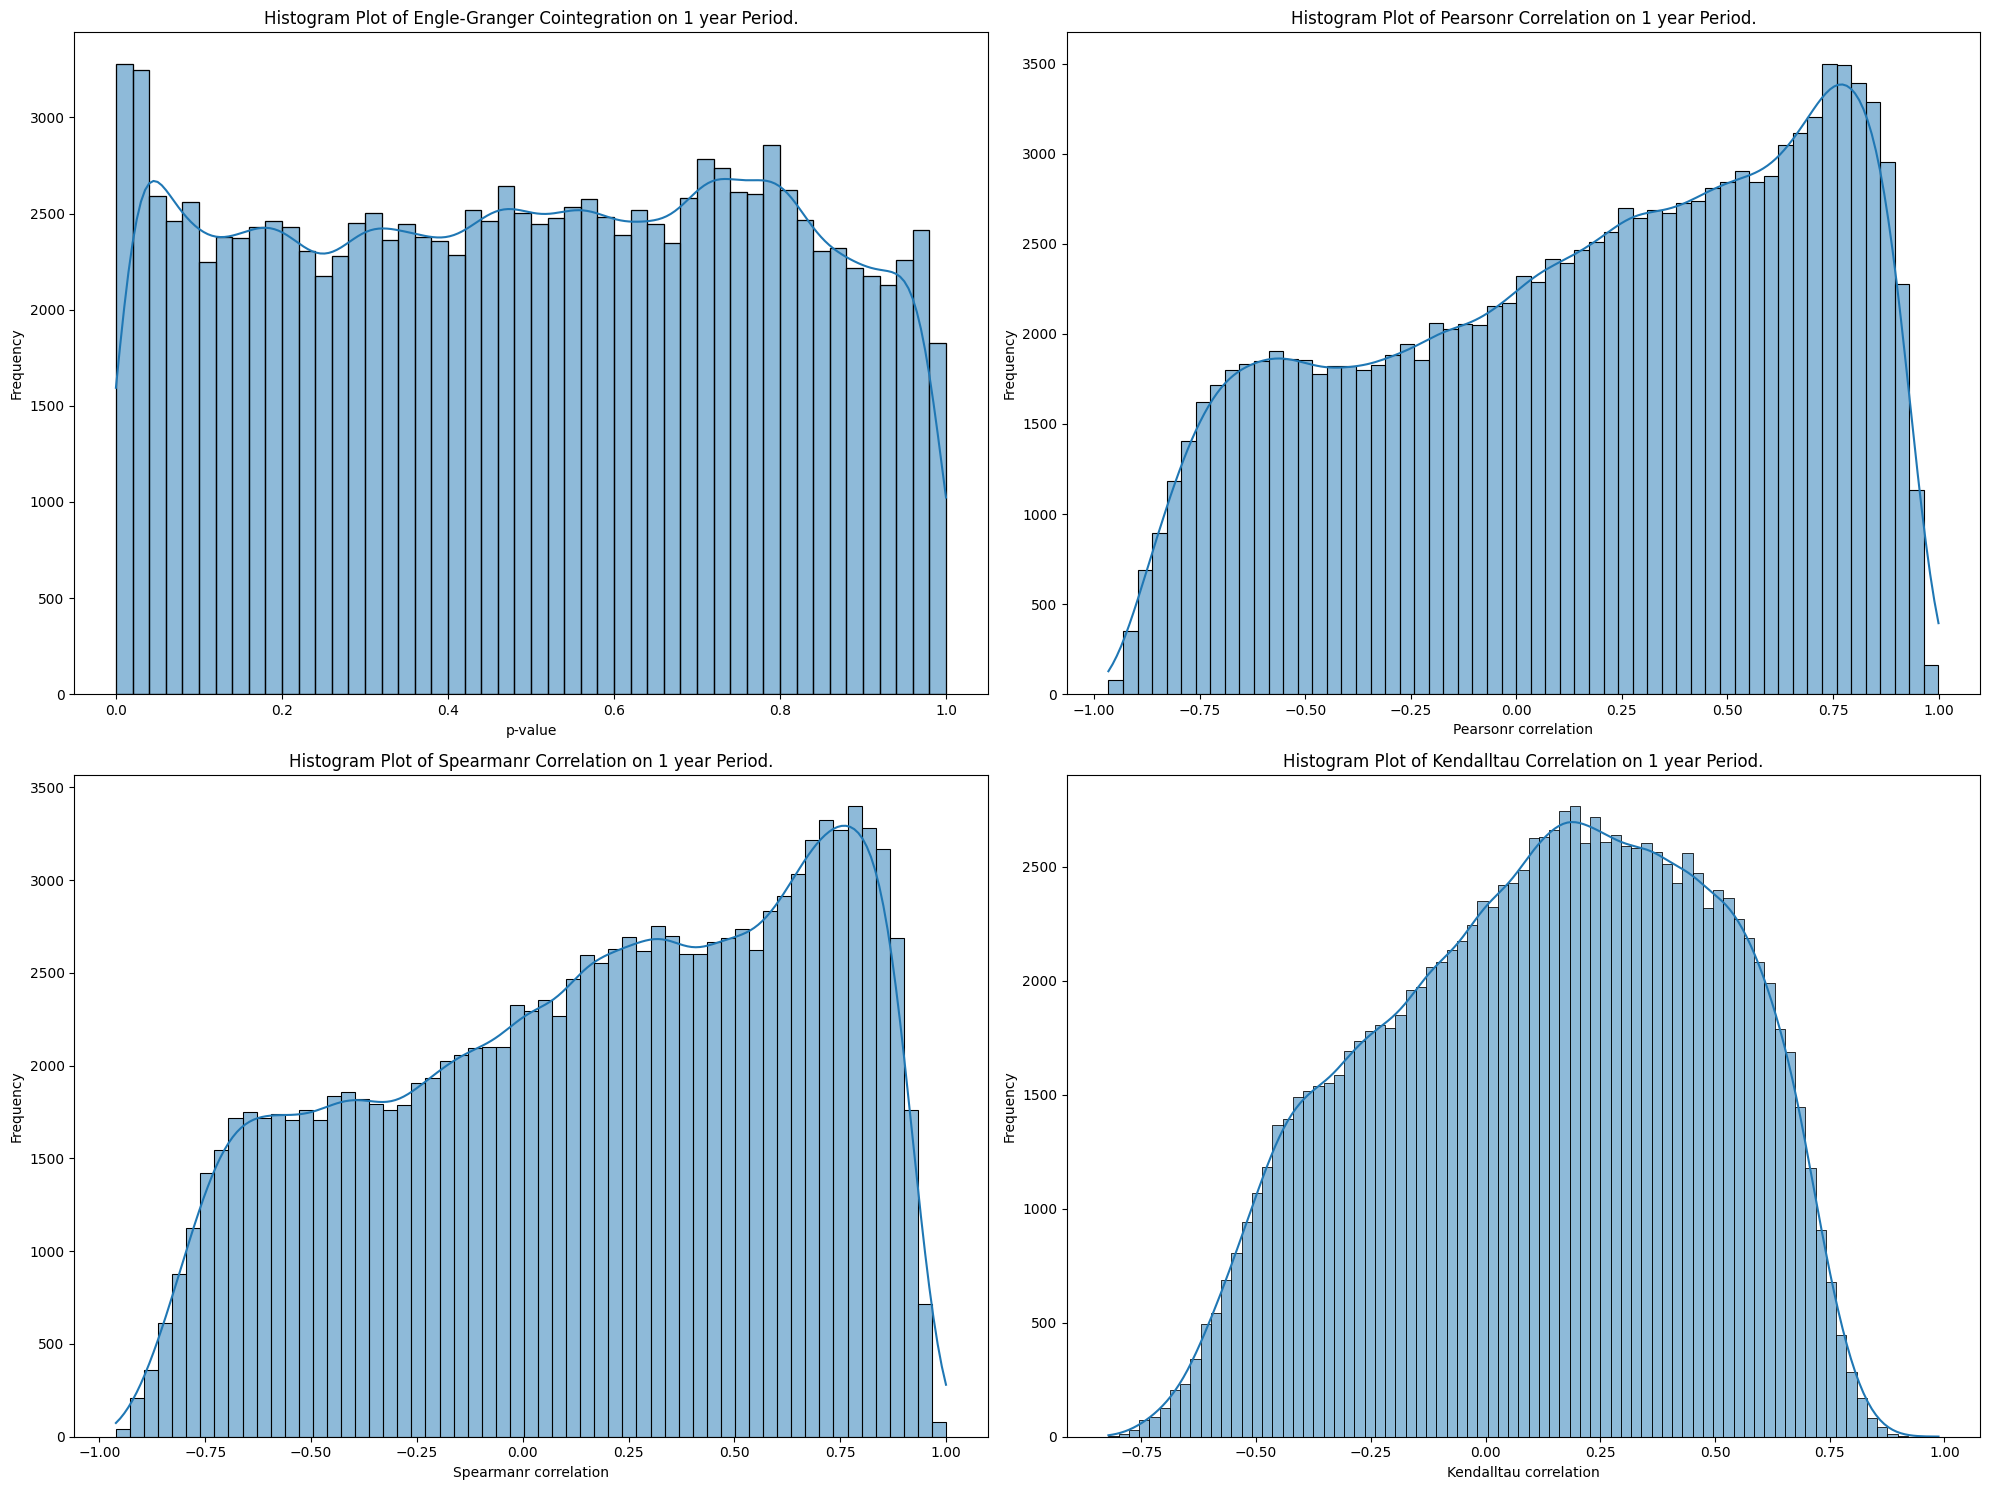

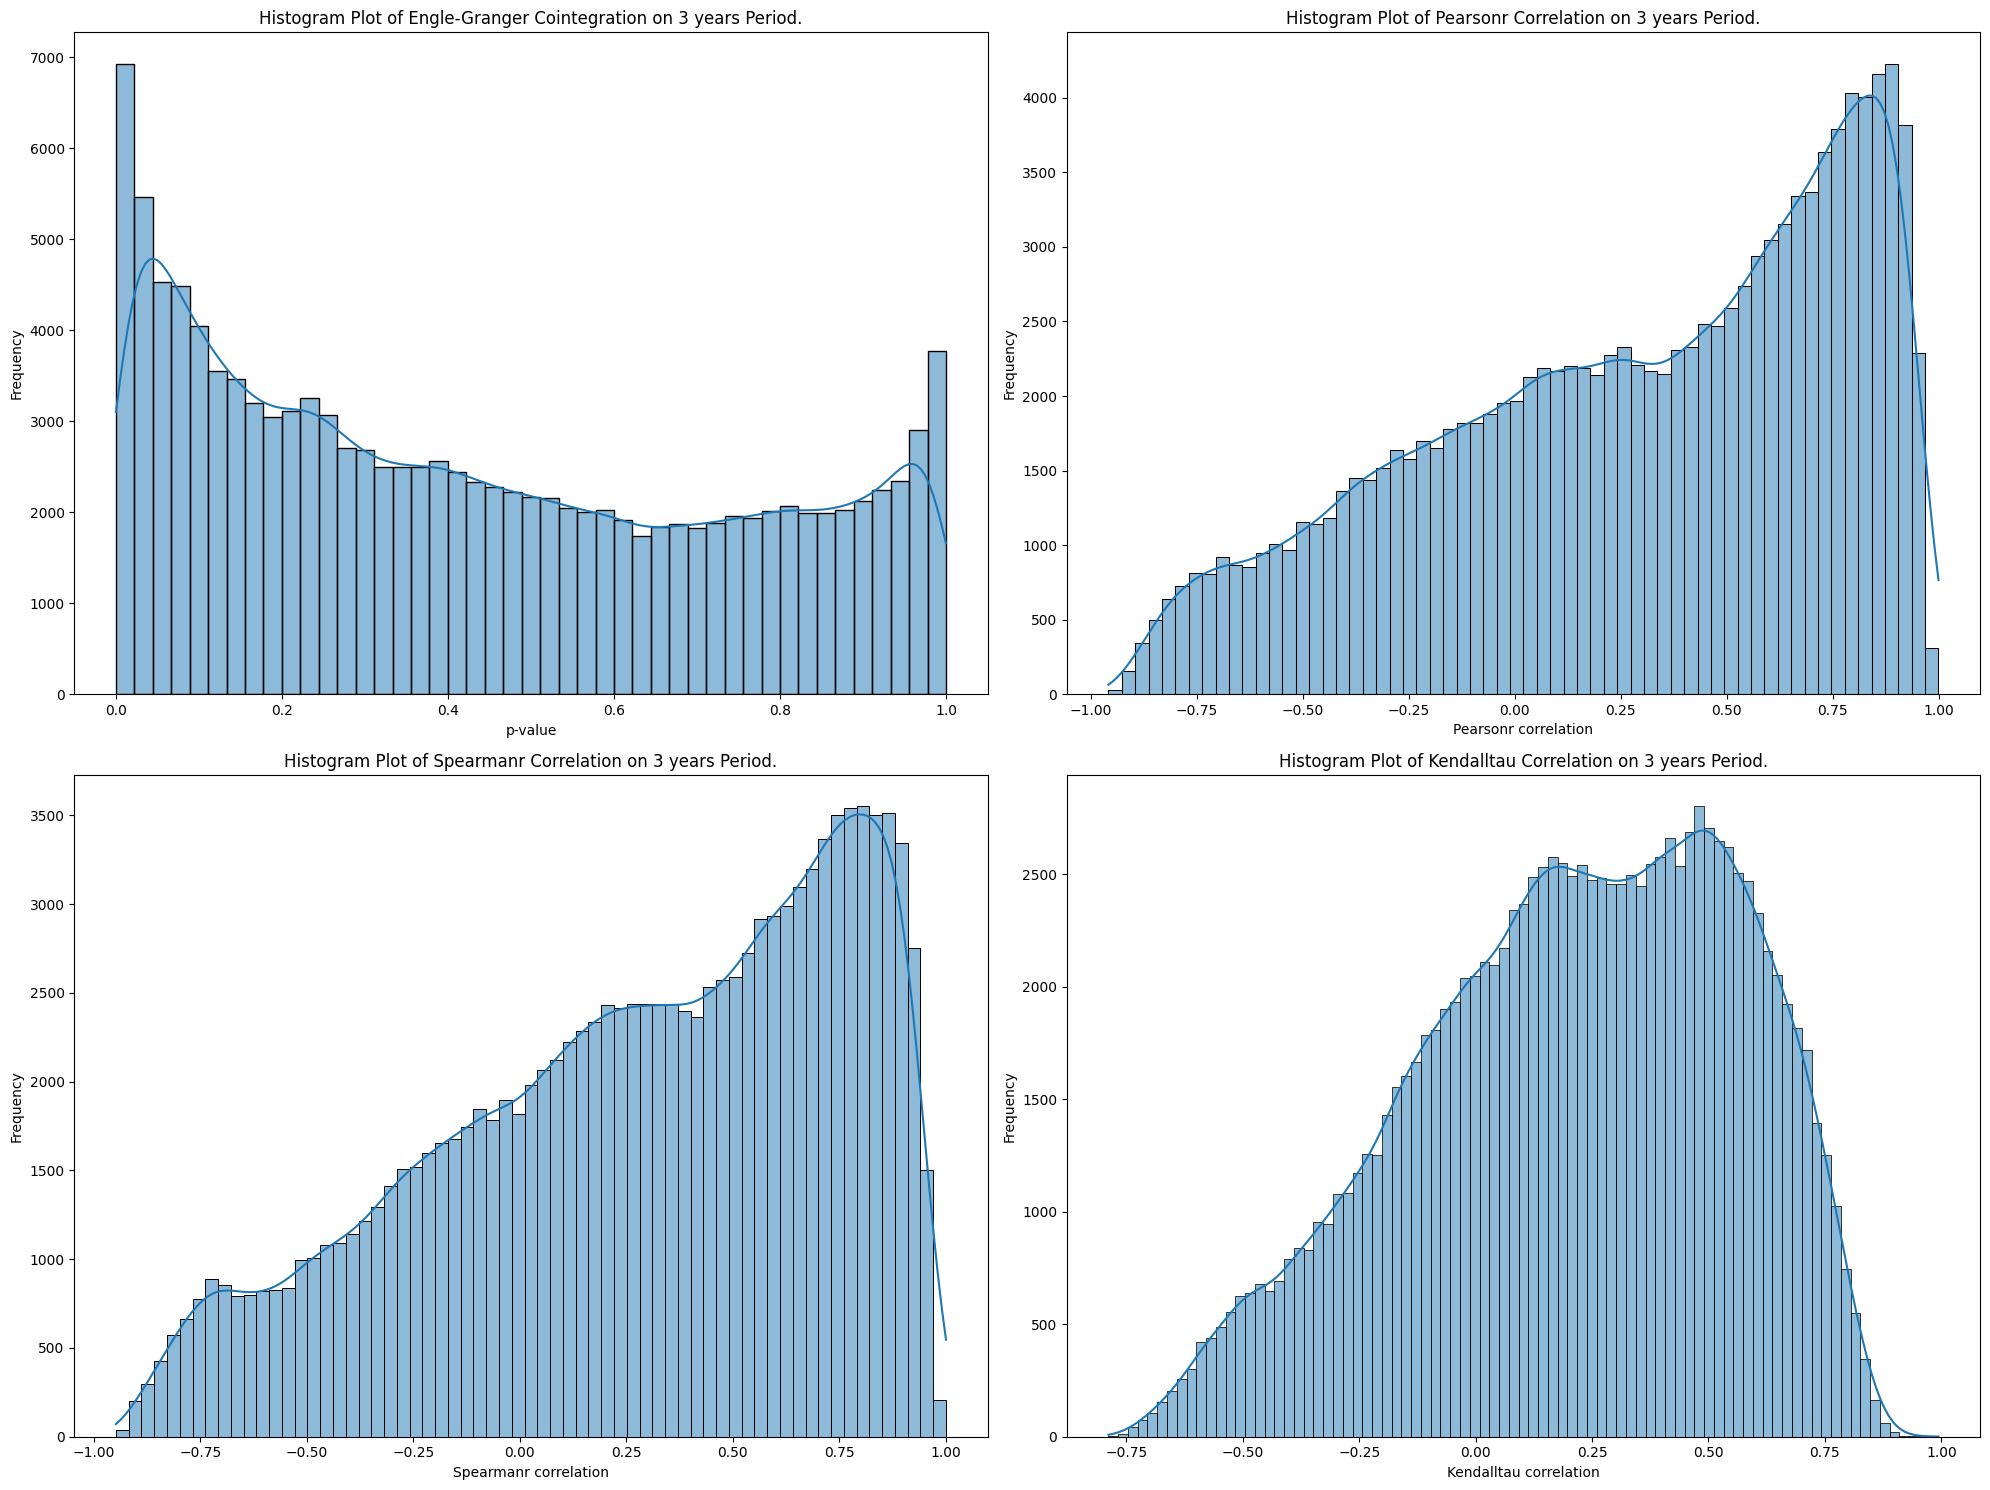

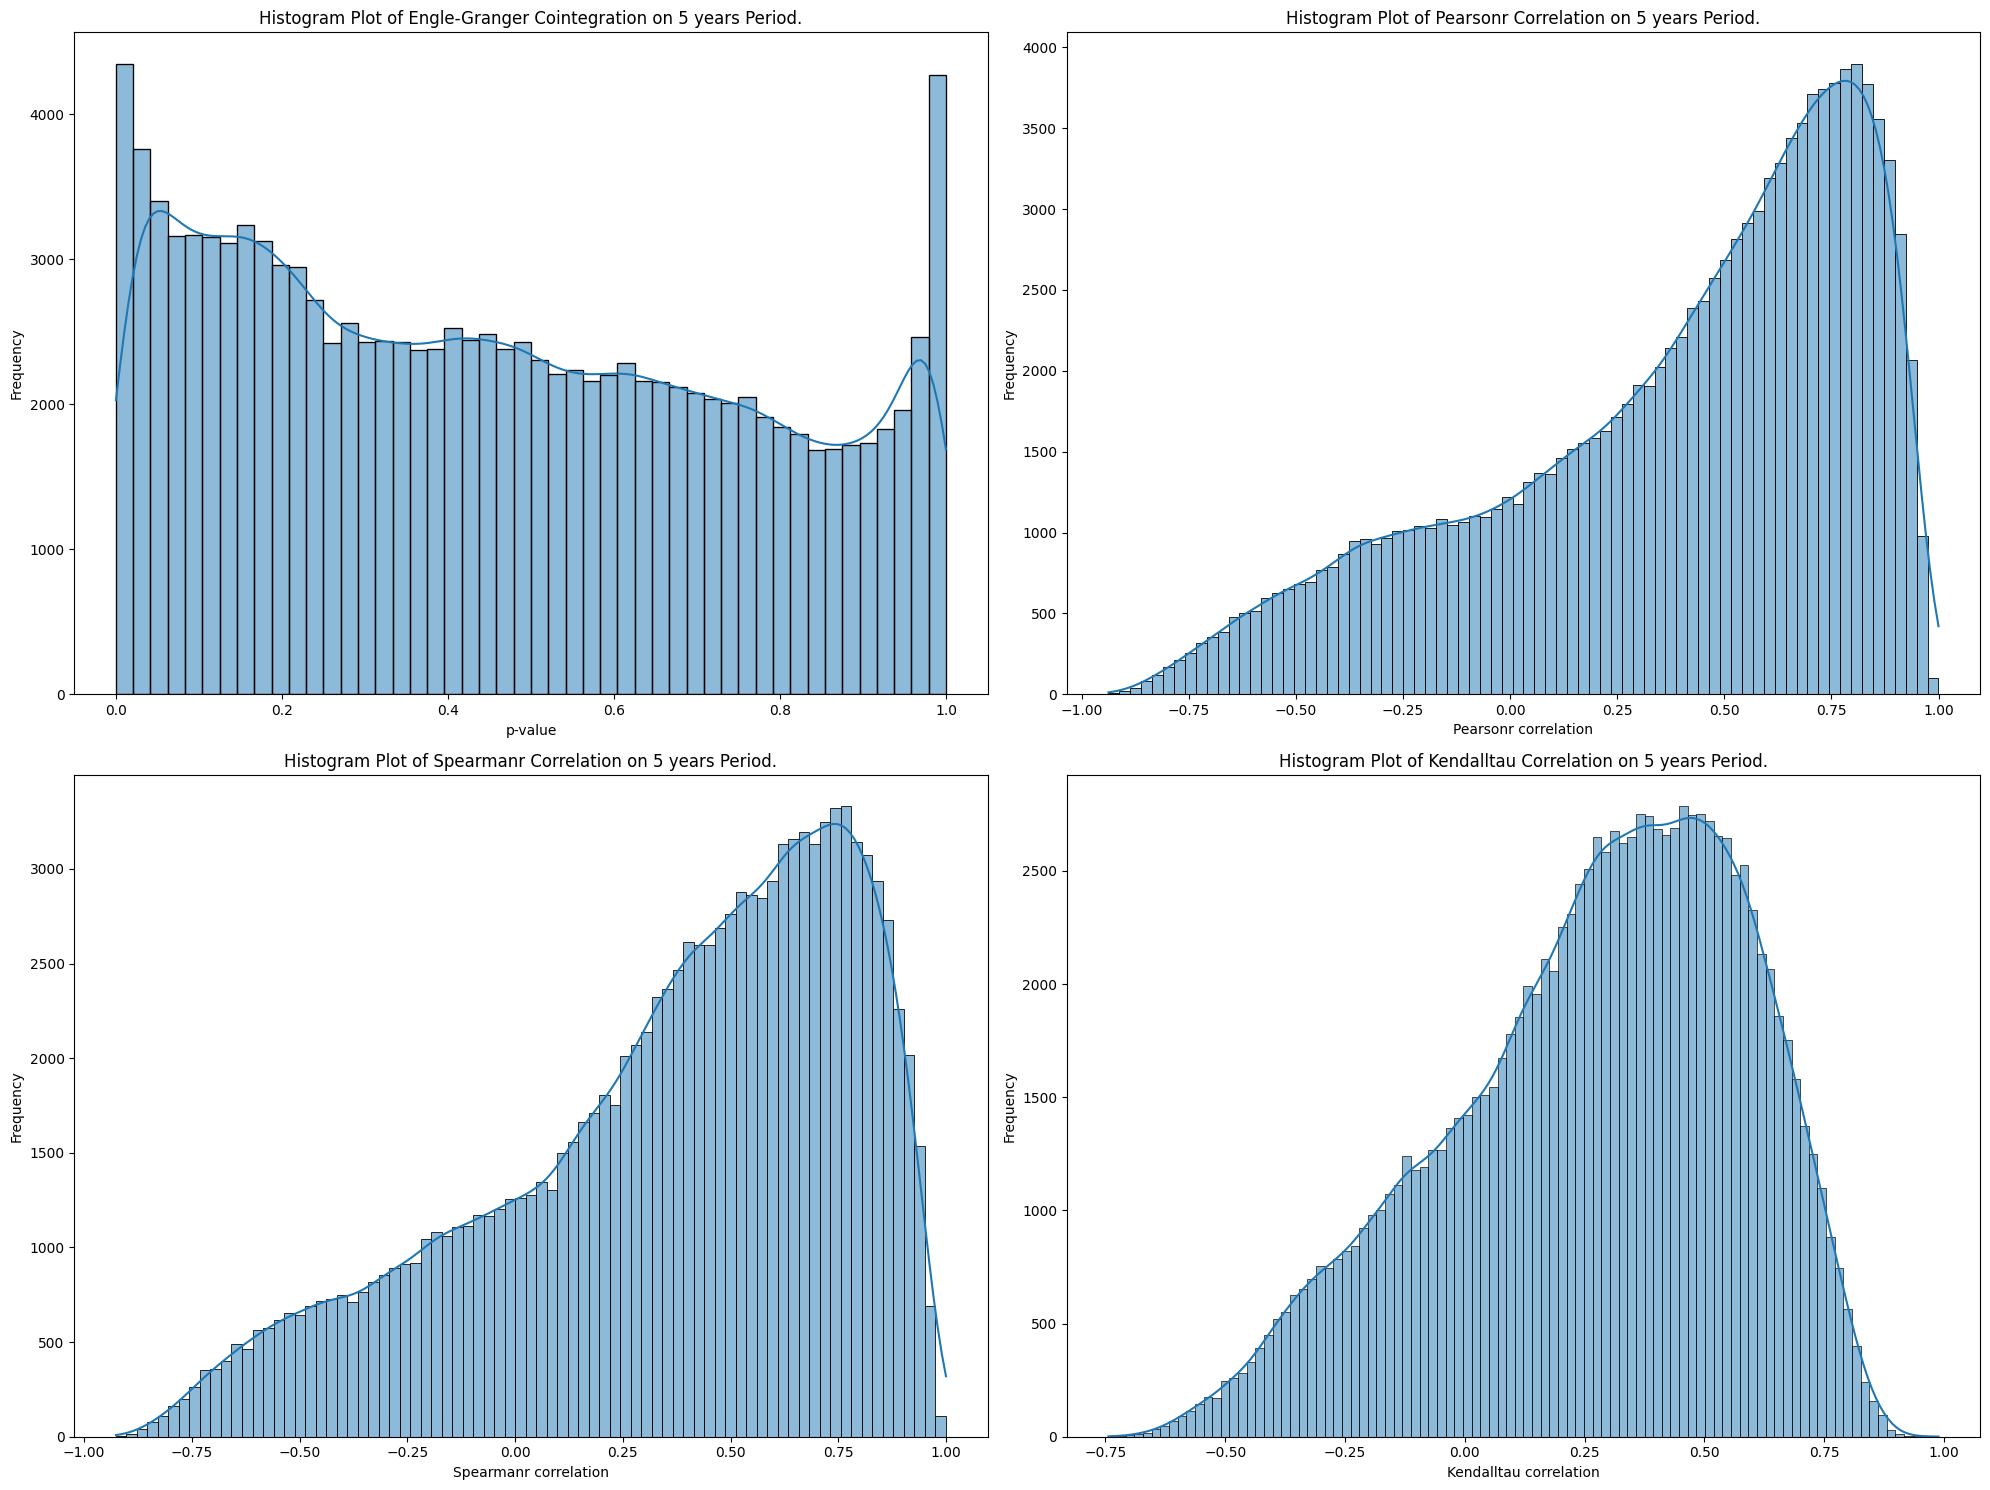

In [6]:
plot_coint_corr = PlotCointCorr(date="2025-04-01")
plot_coint_corr.run()

## [Analyze AAPL](#table-of-contents)


In [46]:
analyze_coint = AnalyzeCoint()
df_coint_analysis = analyze_coint("AAPL")
df_coint_analysis

,date1,period1,top_20_tickers1,date2,period2,top_20_tickers2,num_common,common_tickers
0,2025-03-28,1,"MOS, TJX, LII, VLO, PSX, CSGP, KMX, GEN, ZBH, ...",2025-03-28,3,"APA, EL, VRSK, WBA, ARE, DVN, ORCL, OXY, TYL, ...",0,
1,2025-03-28,1,"MOS, TJX, LII, VLO, PSX, CSGP, KMX, GEN, ZBH, ...",2025-03-28,5,"PG, INCY, MSI, SO, ORCL, HPE, ANET, PANW, PWR,...",0,
2,2025-03-28,3,"APA, EL, VRSK, WBA, ARE, DVN, ORCL, OXY, TYL, ...",2025-03-28,5,"PG, INCY, MSI, SO, ORCL, HPE, ANET, PANW, PWR,...",5,"ORCL, PANW, ANET, DG, PWR"


# [News](#table-of-contents)


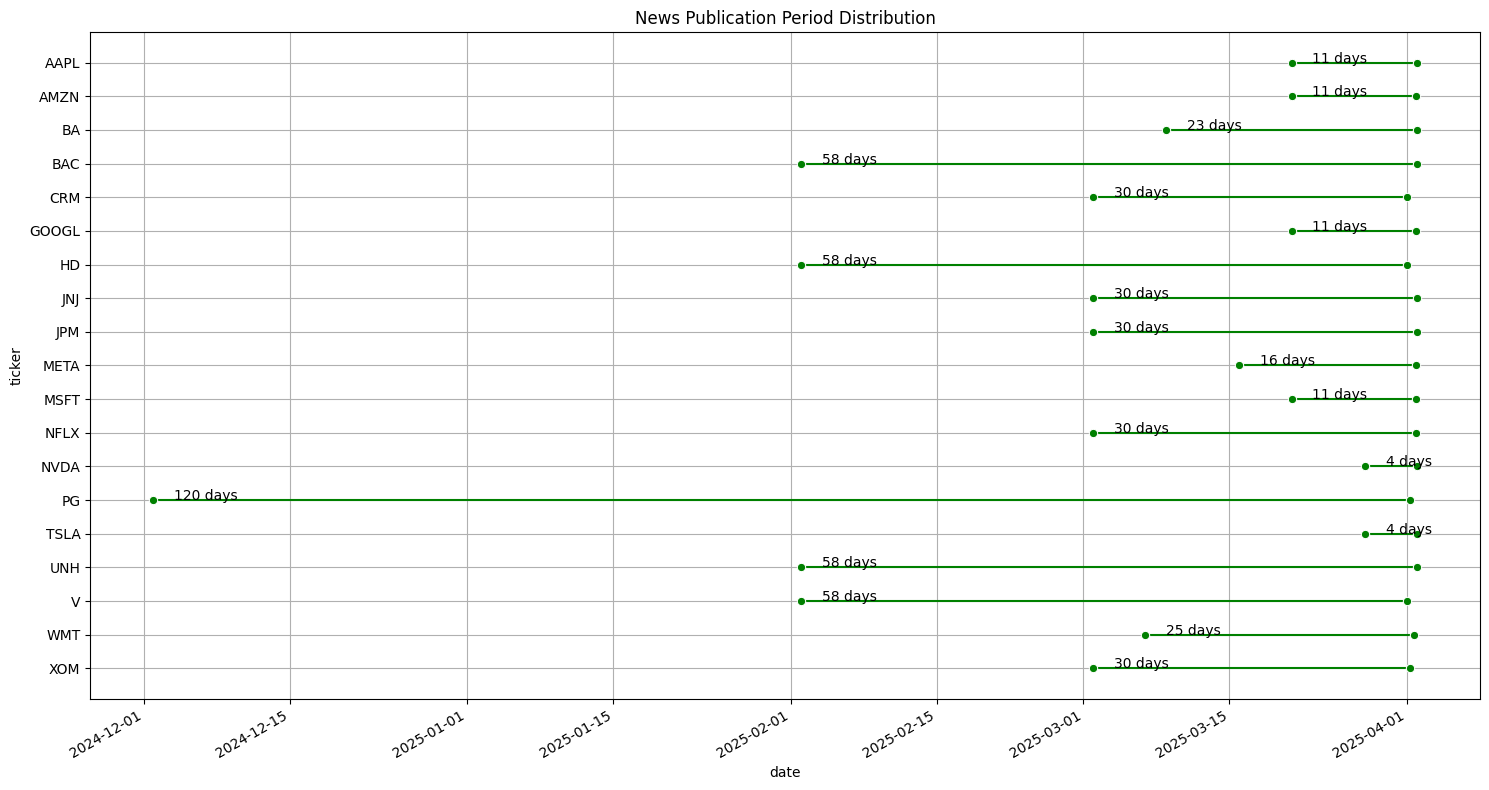

In [19]:
df = pd.read_csv("./data/results/2025-04-01/news.csv")

plot_news = PlotNews(date="2025-04-01")
plot_news.plot_date(df, "date")

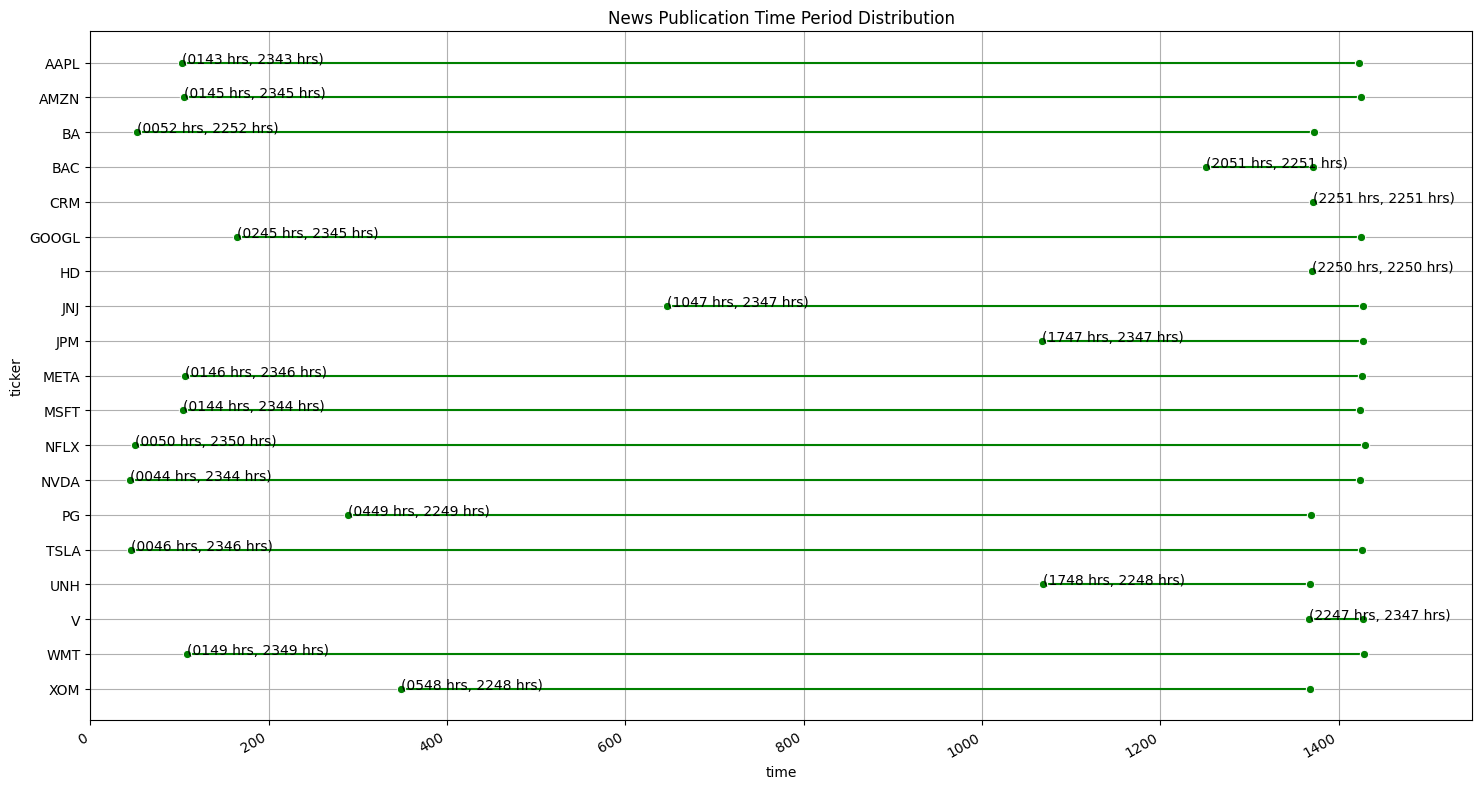

In [22]:
plot_news.plot_time(df, "time", value_vars=["min_minutes", "max_minutes"])

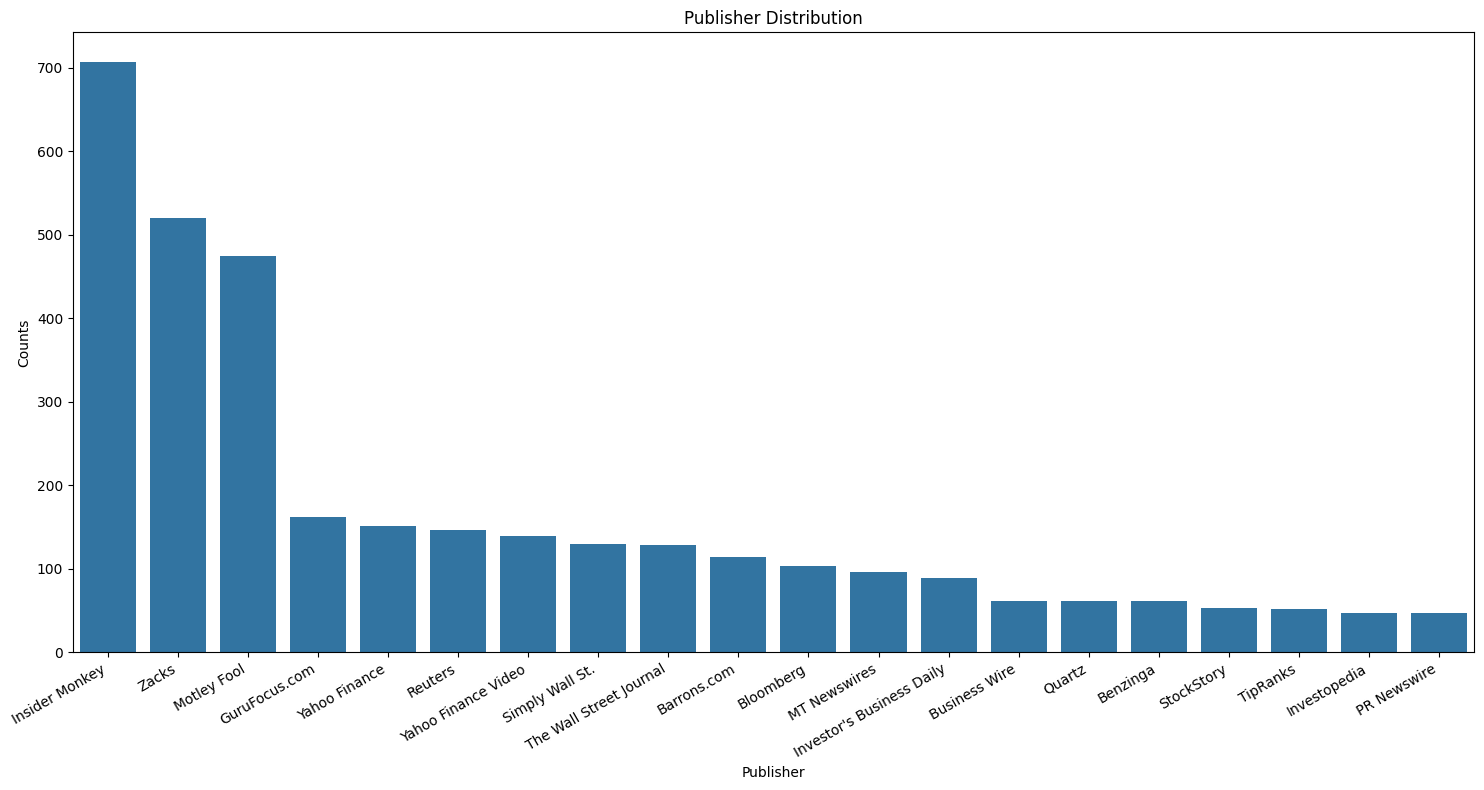

In [23]:
plot_news.plot_publisher(df)

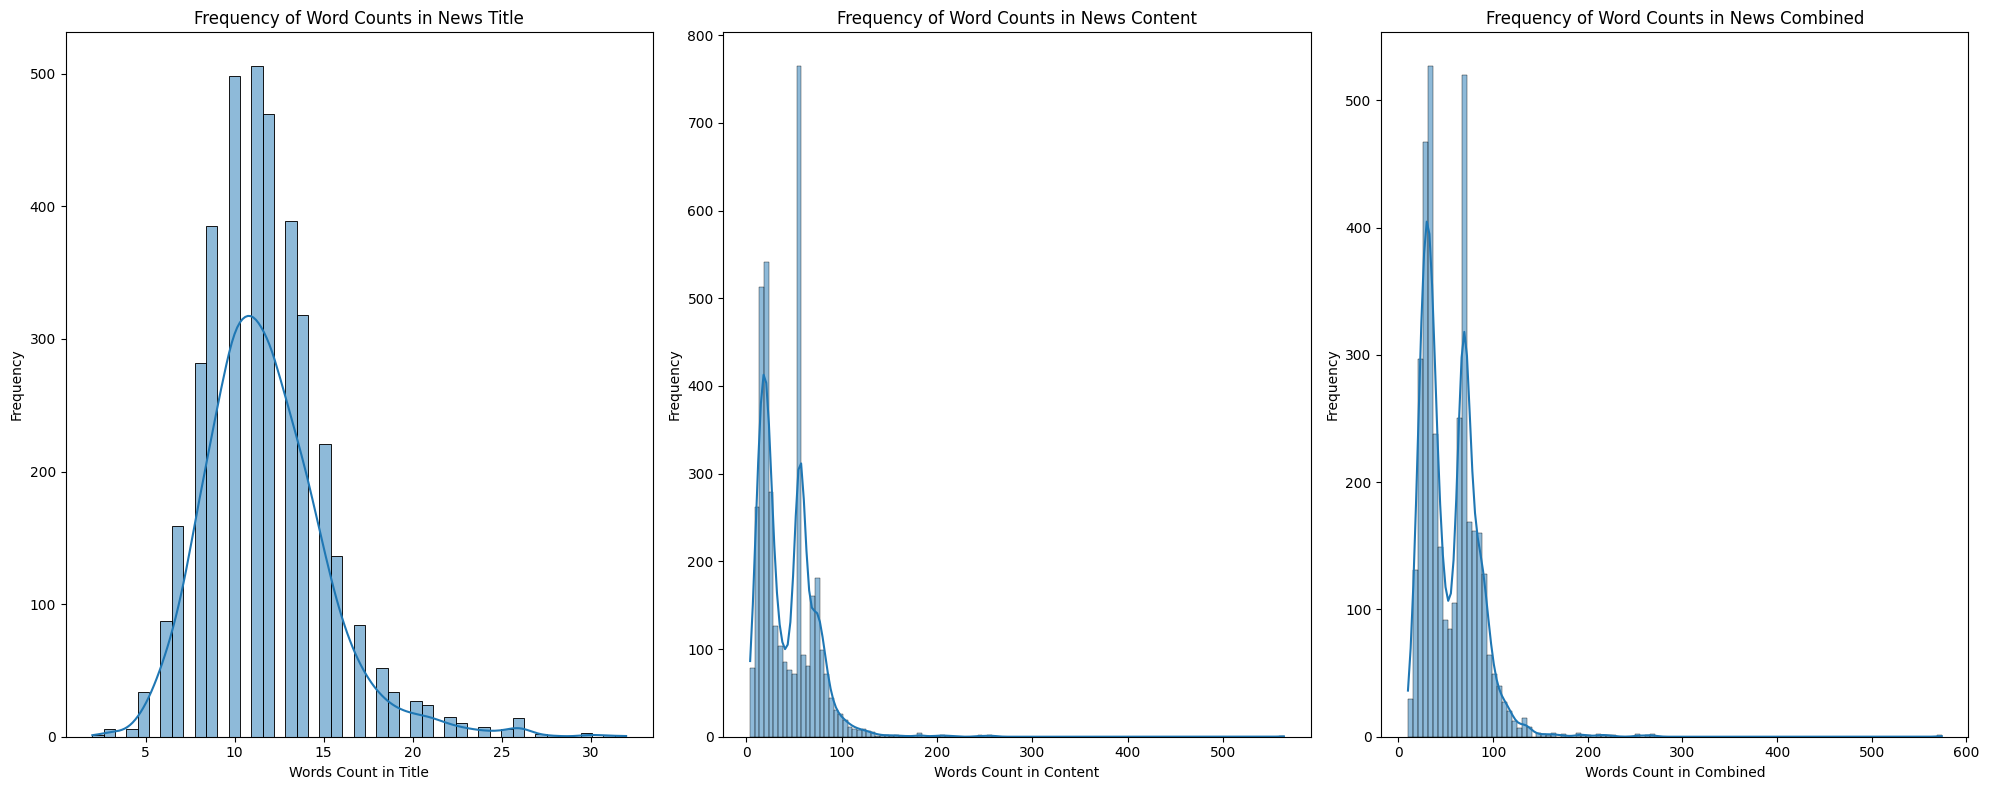

In [24]:
plot_news.plot_word_count(df)

<string>:22: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
<string>:22: UserWarning: Glyph 128674 (\N{SHIP}) missing from font(s) DejaVu Sans.
<string>:22: UserWarning: Glyph 128137 (\N{SYRINGE}) missing from font(s) DejaVu Sans.
<string>:23: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
<string>:23: UserWarning: Glyph 128674 (\N{SHIP}) missing from font(s) DejaVu Sans.
<string>:23: UserWarning: Glyph 128137 (\N{SYRINGE}) missing from font(s) DejaVu Sans.
<string>:22: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
<string>:22: UserWarning: Glyph 128674 (\N{SHIP}) missing from font(s) DejaVu Sans.
<string>:22: UserWarning: Glyph 128137 (\N{SYRINGE}) missing from font(s) DejaVu Sans.
<string>:23: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
<string>:23: UserWarning: Glyph 128674 (\N{

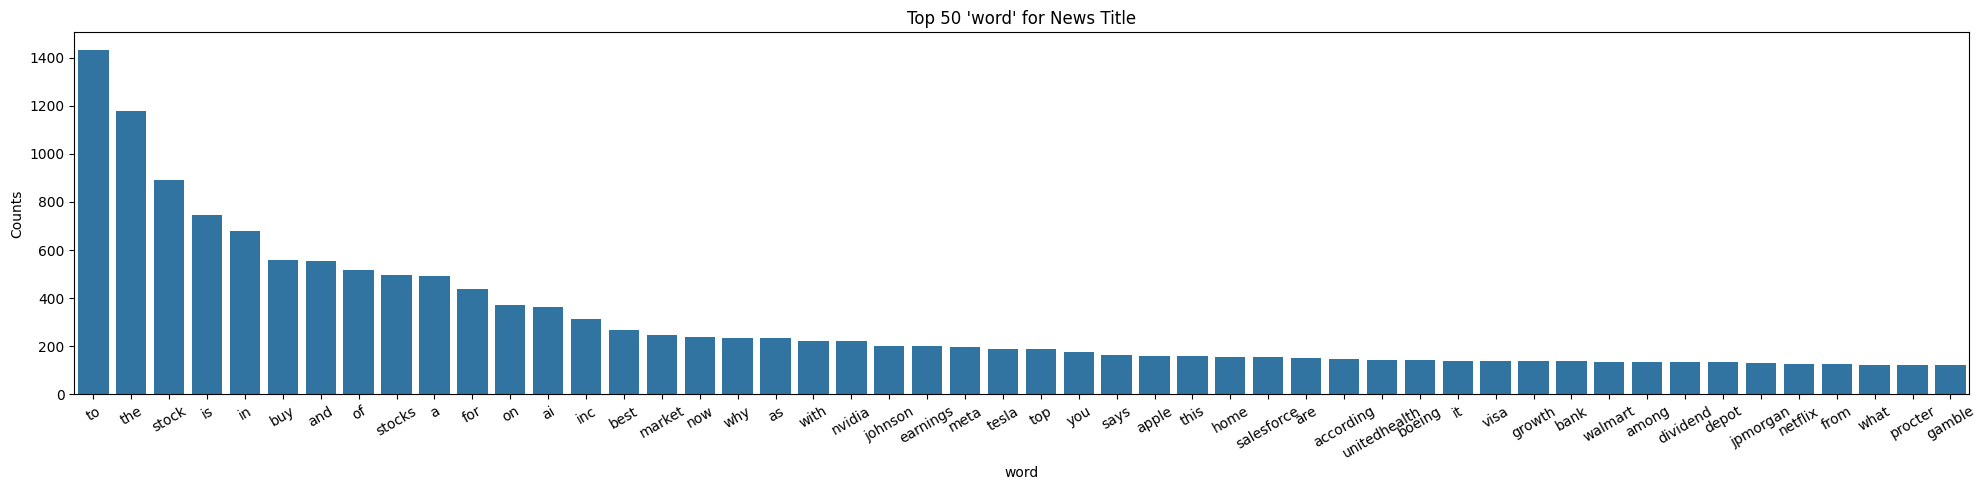

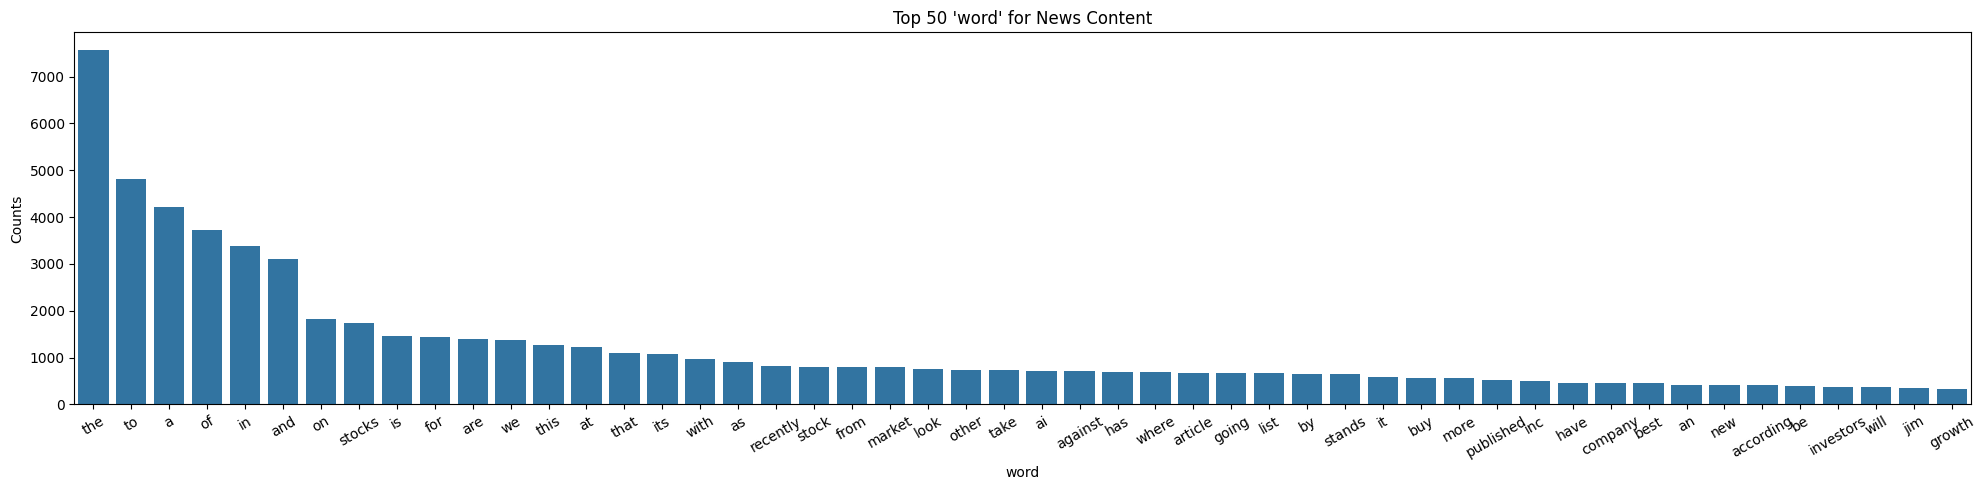

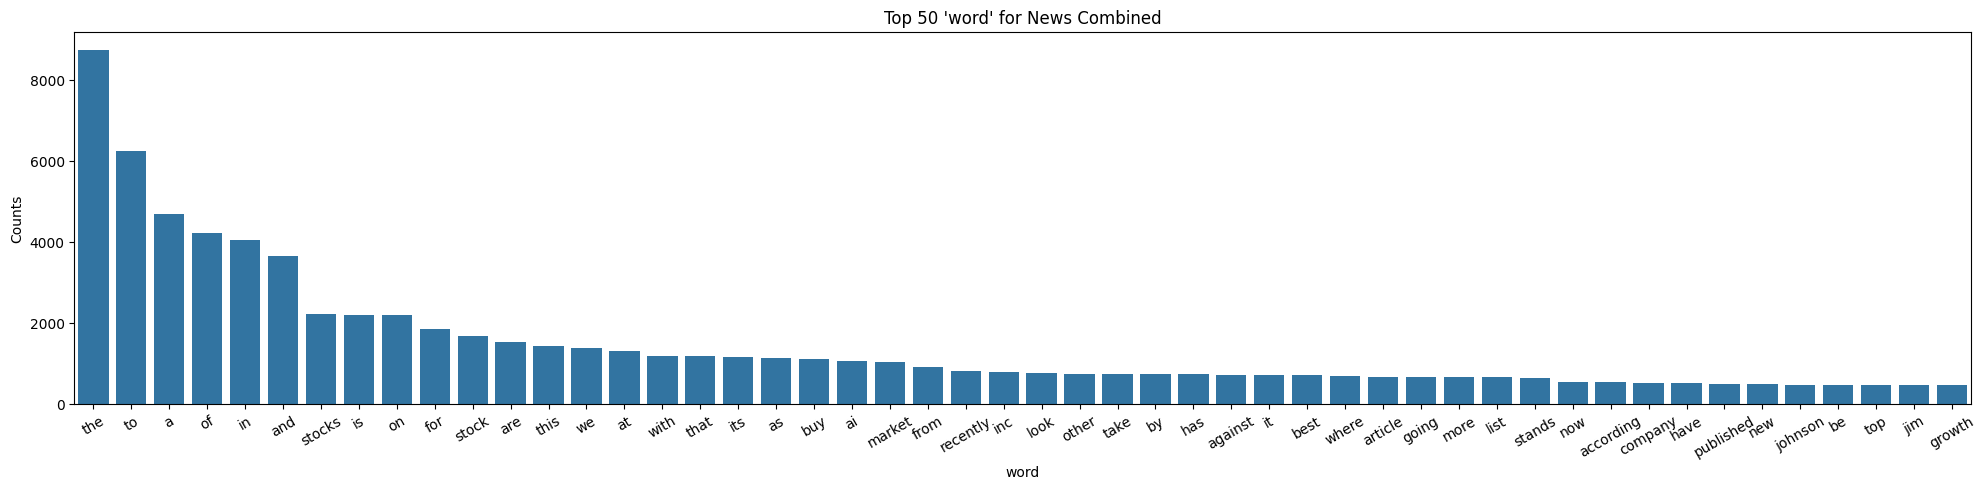

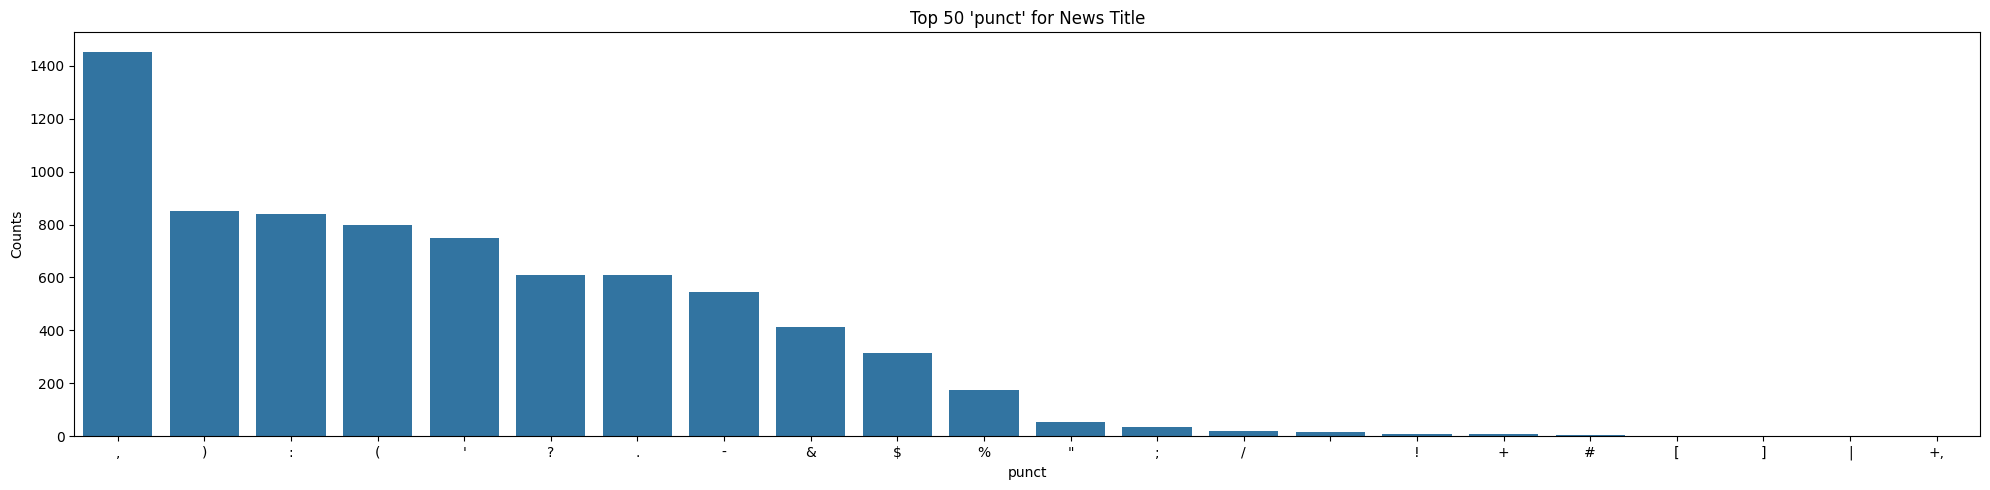

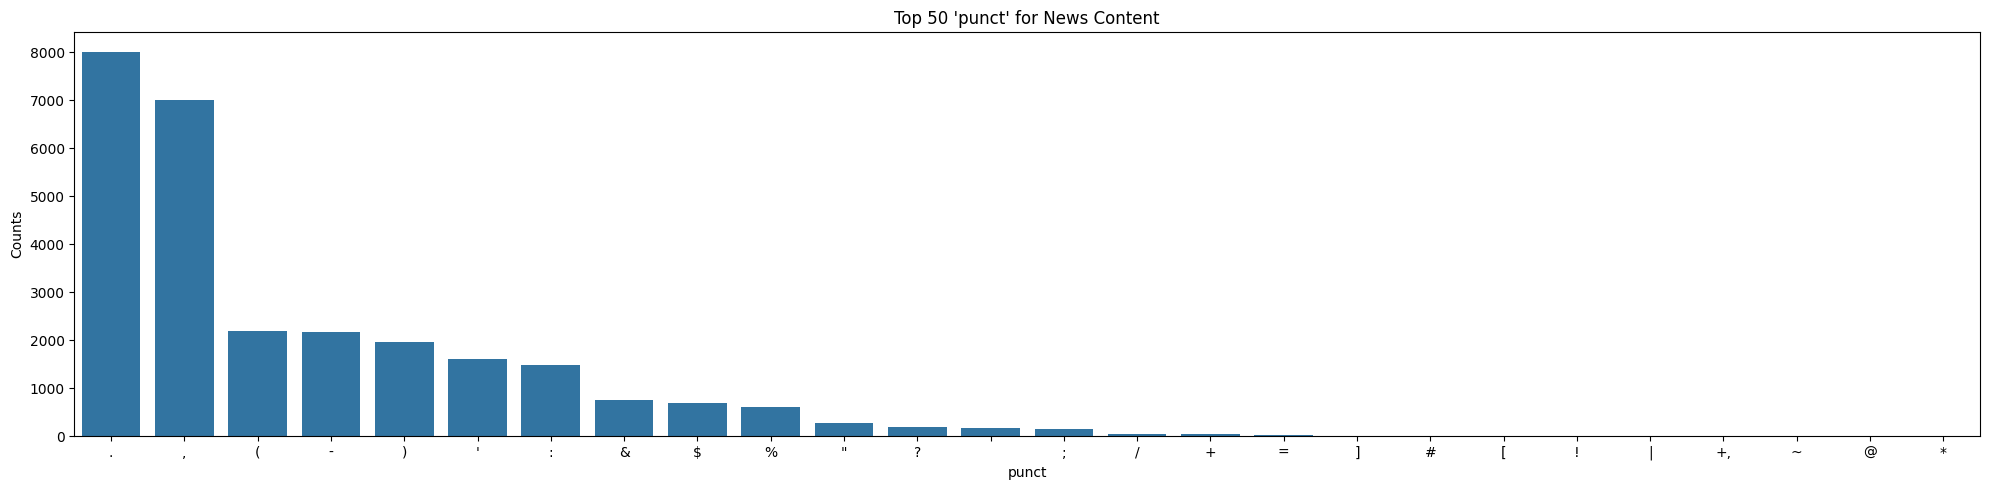

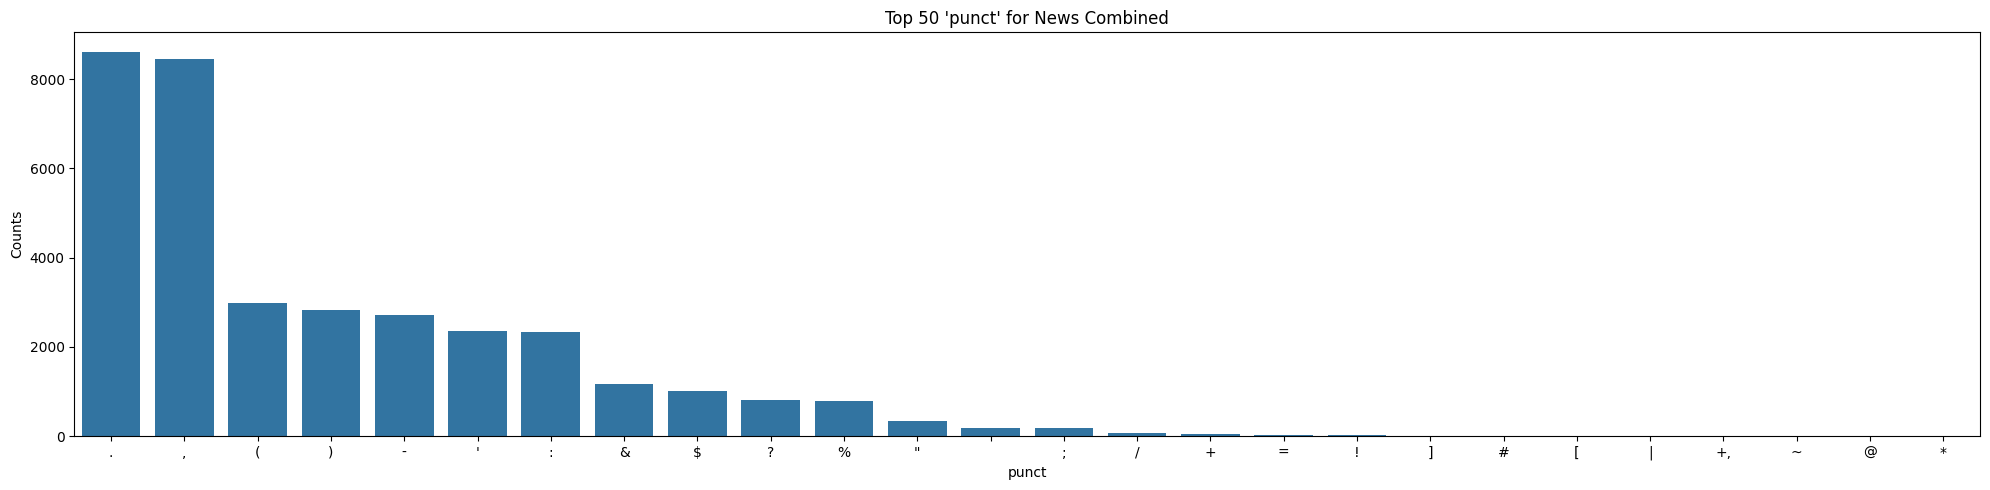

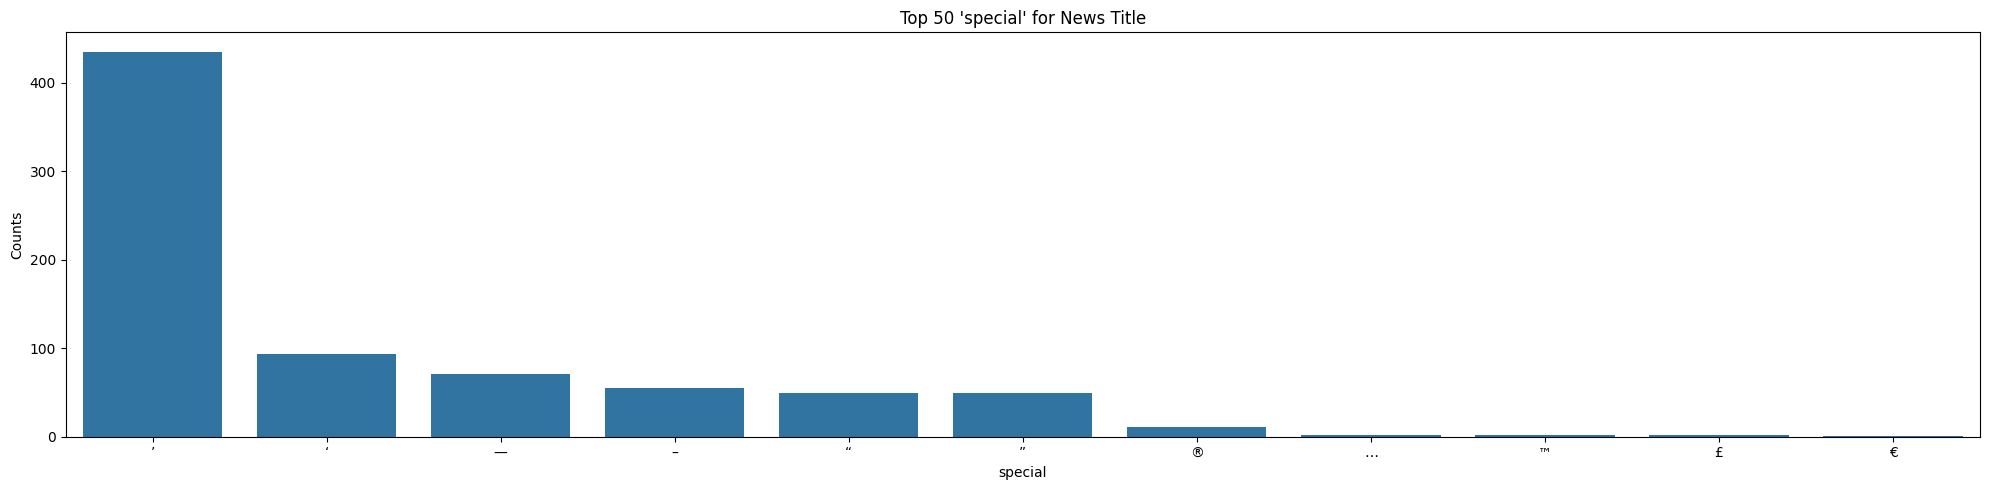

/home/ckabundant/miniconda3/envs/web/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ckabundant/miniconda3/envs/web/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128674 (\N{SHIP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ckabundant/miniconda3/envs/web/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128137 (\N{SYRINGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


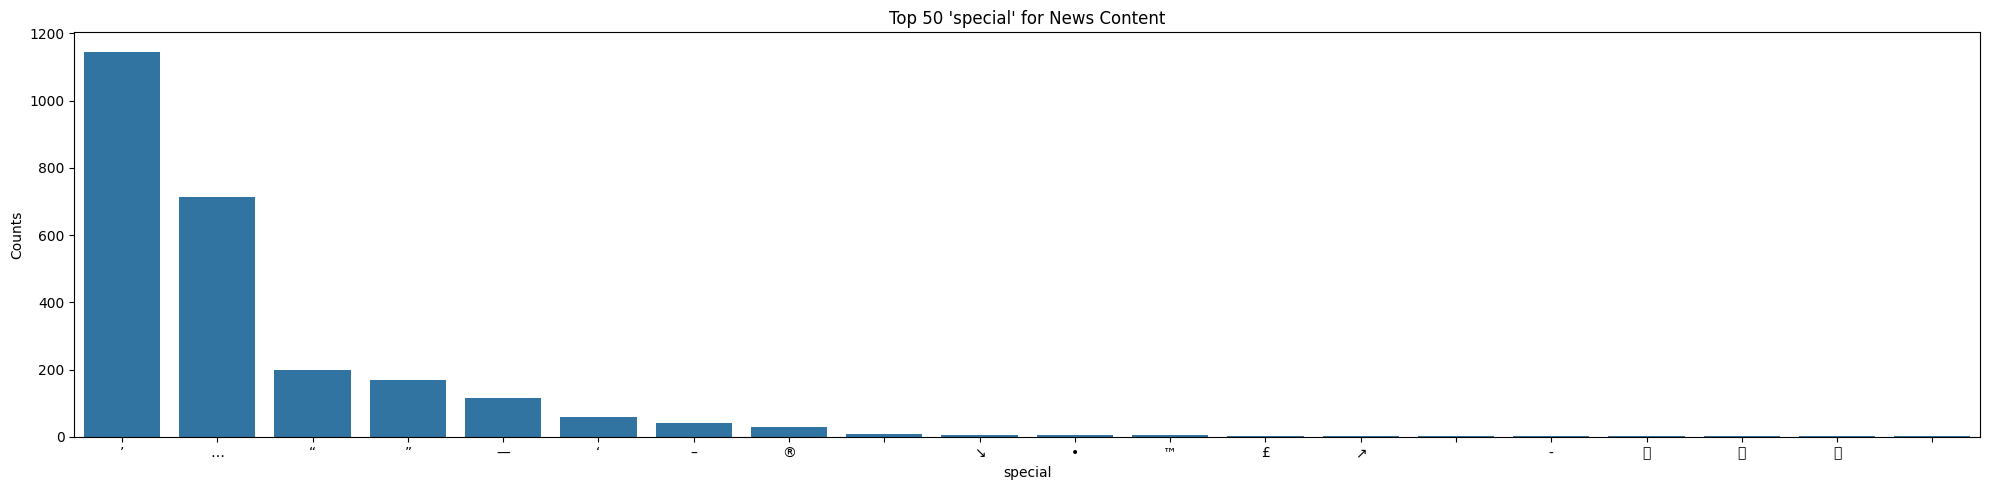

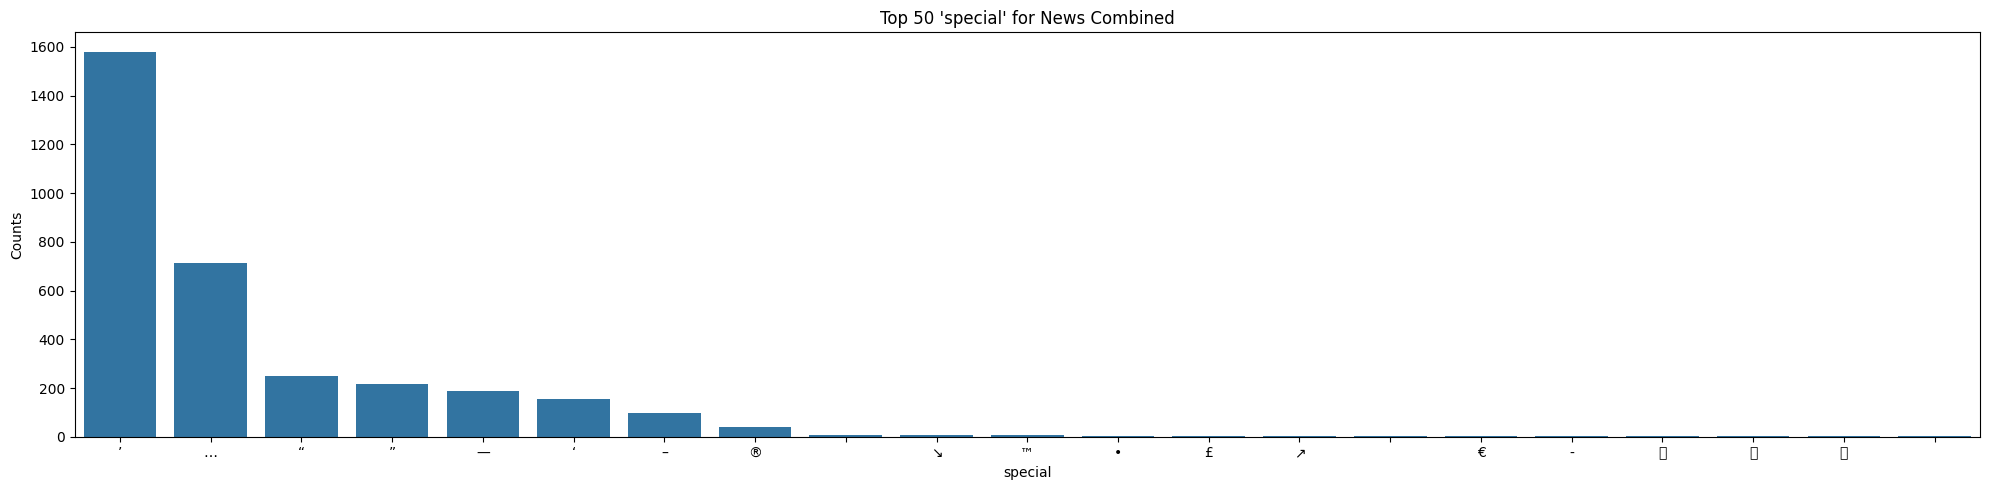

In [25]:
plot_news.plot_top_n(df)

In [3]:
print(df["ticker"].nunique())
df["ticker"].unique()

19


array(['AAPL', 'NVDA', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'JPM',
       'JNJ', 'V', 'XOM', 'UNH', 'WMT', 'PG', 'HD', 'NFLX', 'CRM', 'BAC',
       'BA'], dtype=object)

# [Sentiment](#table-of-contents)

- Capture publication date, publisher (e.g. Bloomberg), news title and news content via yfinance news filtered by ticker e.g. https://finance.yahoo.com/quote/AAPL/news/
- Use different HuggingFace FinBERT on news title only, news content only and both news title and content:

| FinBERT                                                                                    | Model Card                            | Column      | Description                                                                                                                                                      |
| ------------------------------------------------------------------------------------------ | ------------------------------------- | ----------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| [Prosus AI](https://huggingface.co/ProsusAI/finbert)                                       | ProsusAI/finbert                      | prosusai    | &bull; Pre-trained NLP model to analyze sentiment of financial text. <br>&bull; Used Financial PhraseBank by Malo et al. (2014) is used for fine-tuning.         |
| [finbert-tone](https://huggingface.co/yiyanghkust/finbert-tone)                            | yiyanghkust/finbert-tone              | yiyanghkust | &bull; Pre-trained on corporate reports, earning calls, and analyst reports. <br>&bull; Fined-tuned on 10,000 manually annotated sentences from analyst reports. |
| [FinBERT-FOMC](https://huggingface.co/ZiweiChen/FinBERT-FOMC)                              | ZiweiChen/FinBERT-FOMC                | ziweichen   | &bull; Fine-tuned version of ProsusAI/finbert. <br>&bull; Fine-tuned on data useed in FOMC minutes from Jan 2006 to Feb 2023.                                    |
| [finbert-sentiment-analysis](https://huggingface.co/AventIQ-AI/finbert-sentiment-analysis) | AventIQ-AI/finbert-sentiment-analysis | aventiq_ai  | &bull; FinBERT model fine-tuned for sentiment analysis using English/Quotes dataset.                                                                             |

## Observations

- In general, FinBERT is able to rate the sentiment correctly to a certain extent.
- Different variants perform differently based on the fine-tuned dataset - 262 news (out of 3791) are rated as both negative and positive concurrently based on 28 March analysis.
- 'FinBERT-FOMC' appears to have more consistent rating among the 4 (Needs further investigations).


In [ ]:
df = pd.read_csv("./data/results/2025-04-01/sentiment.csv")
df

,pub_date,ticker,publisher,period,title,content,prosusai,prosusai_title,prosusai_content,yiyanghkust,yiyanghkust_title,yiyanghkust_content,ziweichen,ziweichen_title,ziweichen_content,aventiq_ai,aventiq_ai_title,aventiq_ai_content
0,2025-04-01 18:43:00,AAPL,Yahoo Finance Video,4 hours ago,Why this tech investor is on a buying strike,Harvest Portfolio Management chief investment ...,3,3,3,3,3,3,3,3,3,3,3,3
1,2025-03-31 23:43:00,AAPL,TechCrunch,23 hours ago,ChatGPT: Everything you need to know about the...,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",3,3,3,5,3,5,5,3,5,5,3,5
2,2025-04-01 22:23:00,AAPL,Investor's Business Daily,20 minutes ago,Warren Buffett Stocks: What's Inside Berkshire...,You must keep up on Warren Buffett stocks: The...,3,3,3,3,3,3,3,3,3,4,3,5
3,2025-04-01 22:14:00,AAPL,Insider Monkey,29 minutes ago,Jim Cramer’s Strategic Insight on Apple (AAPL)...,We recently published a list of Jim Cramer Say...,3,3,3,3,3,3,3,1,3,2,1,3
4,2025-04-01 21:43:00,AAPL,GuruFocus.com,1 hour ago,"Tesla Short Position Now 4th Largest, Trails N...",Tesla Short Bets Soar to 81M Shares as Stock P...,2,3,1,2,3,5,1,3,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,2025-03-10 22:52:00,BA,Investor's Business Daily,22 days ago,Trump Tariffs: Boeing Stock Dives While Archri...,"As Trump tariffs ramp up, Dow Jones aerospace ...",1,1,1,1,3,1,1,3,1,1,1,1
3775,2025-03-08 22:52:00,BA,Reuters,24 days ago,Boeing must face shareholder class action foll...,A federal judge on Friday certified a class ac...,1,1,1,1,1,1,3,2,3,1,1,1
3776,2025-03-08 22:52:00,BA,Reuters,24 days ago,Boeing ties employee incentive plan to company...,"Annual bonuses for more than 100,000 Boeing em...",3,3,3,3,3,3,3,3,3,4,5,2
3777,2025-03-08 22:52:00,BA,The Wall Street Journal,24 days ago,New Boeing Boss Gets $18.4 Million in Pay for ...,Boeing’s new CEO made $18.4 million in compens...,3,3,3,3,3,3,3,3,3,4,5,2


In [ ]:
utils.display_divergent_rating(df)

divergent news : 262


,pub_date,ticker,publisher,period,title,content,prosusai,yiyanghkust,ziweichen,aventiq_ai
30,2025-03-27 07:40:00,AAPL,Motley Fool,yesterday,1 Unstoppable Vanguard ETF to Confidently Buy With $400 During the Stock Market Sell-Off,"The S&P 500 (SNPINDEX: ^GSPC) index returned 25% (including dividends) in 2024, which was more than double its long-term average of 10.5%. The Vanguard Growth ETF (NYSEMKT: VUG) is an exchange-traded fund that tracks the performance of the CRSP Growth Index by holding the same stocks and maintaining similar weightings, and it has outperformed the S&P 500 every year, on average, since it was established in 2004. The Vanguard ETF is currently down 11% from its record high amid the broader stock market sell-off, so investors can pick up a single share for under $400.",1,5,3,1
82,2025-03-23 07:40:00,AAPL,Insider Monkey,5 days ago,"Apple (AAPL) Poised for AI Boom Without Heavy GPU Investments, Says Evercore","We recently published a list of 10 High-Flying AI Stocks to Watch Today. In this article, we are going to take a look at where Apple Inc. (NASDAQ:AAPL) stands against other high-flying AI stocks to watch today. The most important conference in the tech world is in full swing, yet investors are skeptical about what’s […]",3,1,1,5
95,2025-03-22 07:40:00,AAPL,Zacks,6 days ago,Severance's Fame is Good for Apple TV+: Is it True for AAPL Stock?,"Severance's success bodes well for Apple's Services business. However, Apple Intelligence delays, stretched valuation, and China headwinds are concerns in 2025.",2,5,1,1
96,2025-03-22 07:40:00,AAPL,Medical Device Network,6 days ago,"Apple’s hearing aid software is impressive, but audiologists still matter",An expert from the Royal National Institute for Deaf People is enthusiastic about the innovation but cautions about its medical limitations.,2,5,3,1
120,2025-03-21 07:40:00,AAPL,GuruFocus.com,7 days ago,Apple's $1 Billion Streaming Sinkhole: Is This the Costliest Gamble in Tech?,Apple TV+ is bleeding cash while rivals dominate--yet investors remain unfazed. Is Apple quietly rewriting the streaming playbook?,1,5,2,1
125,2025-03-21 07:40:00,AAPL,GuruFocus.com,7 days ago,Apple TV+ Inches to 45M Users as Losses Reach $1B Yearly,Apple TV+ is nearing 45 million subscribers despite incurring approximately $1 billion in losses each year,2,4,5,1
134,2025-03-21 07:40:00,AAPL,Motley Fool,7 days ago,Will Apple's Slow Artificial Intelligence Rollout Help or Hurt the Stock?,"Artificial intelligence (AI) is a huge opportunity for a device maker like Apple (NASDAQ: AAPL) to take advantage of. With more than 2.2 billion active Apple devices in the world, if the company can use AI to help create a new income stream for its operations, that can be a huge growth catalyst for the business, which is something Apple needs given its underwhelming growth in recent years. While the company has announced plans for Apple Intelligence to run on its phones and for that to potentially lead to more sales, it's been lagging behind its rivals.",5,5,1,5
145,2025-03-20 07:40:00,AAPL,Yahoo Finance,8 days ago,Nvidia's GTC fallout reminds 'Magnificent 7' investors of an important lesson,"Nvidia is still the straw that stirs the drink for the ""Magnificent Seven.""",3,1,4,5
171,2025-03-19 07:40:00,AAPL,Insider Monkey,9 days ago,Apple(NASDAQ:AAPL) Bullish on AI Supercycle vs. Cautious on Current Progress,"Recently we took a detailed look at the Top 10 Trending Stocks and Apple Inc. (NASDAQ:AAPL) was one of the stocks that were highlighted in that article. The volatile tariff policies of the new US administration and a slowdown in AI-related enthusiasm took a toll on the market over the past few weeks. However, some analysts […]",3,5,2,1
179,2025-03-19 07:40:00,AAPL,Motley Fool,9 days ago,"Apple Partner Globalstar Just Set a New Record, but Did You Even Notice?","On Feb. 27, satellite communications company Globalstar (NASDAQ: GSAT) reported the end of its best revenue year ever. Two weeks after announcin

# [Trade Results](#table-of-contents)


In [35]:
results = utils.load_csv(
    "./data/results/2025-03-28/ziweichen_coint_5/trade_results.csv"
)
results

,ticker,coint_ticker,action,entry_date,entry_price,exit_date,exit_price,days_held,profit_loss,percent_ret,daily_ret,win
0,GOOGL,J,buy,2025-03-20,121.89,2025-03-21,121.25,1,-0.64,-0.005251,-0.005251,0
1,GOOGL,J,buy,2025-03-24,123.19,2025-03-25,123.62,1,0.43,0.003491,0.003491,1
2,GOOGL,J,buy,2025-03-26,123.97,2025-03-27,123.44,1,-0.53,-0.004275,-0.004275,0
3,NVDA,MAS,buy,2025-03-26,70.41,2025-03-27,70.46,1,0.05,0.00071,0.00071,1
4,BA,WBD,buy,2025-03-12,10.42,2025-03-13,9.89,1,-0.53,-0.050864,-0.050864,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1175,BA,CMCSA,buy,2025-03-12,35.19,2025-03-13,34.7,1,-0.49,-0.013924,-0.013924,0
1176,BA,CMCSA,buy,2025-03-14,35.43,2025-03-19,36.09,5,0.66,0.018628,0.003698,1
1177,BA,CMCSA,buy,2025-03-18,36.01,2025-03-19,36.09,1,0.08,0.002222,0.002222,1
1178,BA,CMCSA,buy,2025-03-20,36.5,2025-03-25,36.94,5,0.44,0.012055,0.002399,1


# [Overall Summary](#table-of-contents)


In [25]:
a = utils.load_csv("./data/results/2025-04-01/ziweichen_coint_5/overall_summary.csv")
a

,Unnamed: 0,Overall Statistics
0,total_num_stock_tickers,19
1,num_tickers_with_no_trades,3
2,stock_ticker_without_trades,"AAPL, NVDA, TSLA"
3,num_tickers_with_trades,16
4,stock_ticker_with_trades,"UNH, GOOGL, BA, HD, NFLX, XOM, JPM, WMT, META,..."
5,total_num_trades,1030
6,total_num_wins,594
7,total_num_loss,436
8,total_profit,34.55
9,max_loss,-86.43


In [41]:
overall = utils.load_csv(
    "./data/results/2025-04-01/ziweichen_coint_5/overall_summary.csv", index_col=0
)
overall

,Overall Statistics
total_num_stock_tickers,19
num_tickers_with_no_trades,3
stock_ticker_without_trades,"AAPL, NVDA, TSLA"
num_tickers_with_trades,16
stock_ticker_with_trades,"UNH, GOOGL, BA, HD, NFLX, XOM, JPM, WMT, META,..."
total_num_trades,1030
total_num_wins,594
total_num_loss,436
total_profit,34.55
max_loss,-86.43


In [42]:
a = overall.T
a

,total_num_stock_tickers,num_tickers_with_no_trades,stock_ticker_without_trades,num_tickers_with_trades,stock_ticker_with_trades,total_num_trades,total_num_wins,total_num_loss,total_profit,max_loss,...,first_trade,last_trade,min_days_held,max_days_held,mean_days_held,median_days_held,trading_period,total_investment,percent_return,annualized_return
Overall Statistics,19,3,"AAPL, NVDA, TSLA",16,"UNH, GOOGL, BA, HD, NFLX, XOM, JPM, WMT, META,...",1030,594,436,34.55,-86.43,...,2025-03-03,2025-03-26,1,19,5.932038834951456,5.0,24,198422.61,0.000174,0.002650


In [43]:
a.insert(0, "strategy", "aventiq_ai_coint_5")
a

,strategy,total_num_stock_tickers,num_tickers_with_no_trades,stock_ticker_without_trades,num_tickers_with_trades,stock_ticker_with_trades,total_num_trades,total_num_wins,total_num_loss,total_profit,...,first_trade,last_trade,min_days_held,max_days_held,mean_days_held,median_days_held,trading_period,total_investment,percent_return,annualized_return
Overall Statistics,aventiq_ai_coint_5,19,3,"AAPL, NVDA, TSLA",16,"UNH, GOOGL, BA, HD, NFLX, XOM, JPM, WMT, META,...",1030,594,436,34.55,...,2025-03-03,2025-03-26,1,19,5.932038834951456,5.0,24,198422.61,0.000174,0.002650


In [44]:
a = a.reset_index().drop(columns=["index"])
a

,strategy,total_num_stock_tickers,num_tickers_with_no_trades,stock_ticker_without_trades,num_tickers_with_trades,stock_ticker_with_trades,total_num_trades,total_num_wins,total_num_loss,total_profit,...,first_trade,last_trade,min_days_held,max_days_held,mean_days_held,median_days_held,trading_period,total_investment,percent_return,annualized_return
0,aventiq_ai_coint_5,19,3,"AAPL, NVDA, TSLA",16,"UNH, GOOGL, BA, HD, NFLX, XOM, JPM, WMT, META,...",1030,594,436,34.55,...,2025-03-03,2025-03-26,1,19,5.932038834951456,5.0,24,198422.61,0.000174,0.002650


In [45]:
a[["hf_model", "coint_corr_fn", "period"]] = a["strategy"].str.rsplit(
    "_", n=2, expand=True
)
a

,strategy,total_num_stock_tickers,num_tickers_with_no_trades,stock_ticker_without_trades,num_tickers_with_trades,stock_ticker_with_trades,total_num_trades,total_num_wins,total_num_loss,total_profit,...,max_days_held,mean_days_held,median_days_held,trading_period,total_investment,percent_return,annualized_return,hf_model,coint_corr_fn,period
0,aventiq_ai_coint_5,19,3,"AAPL, NVDA, TSLA",16,"UNH, GOOGL, BA, HD, NFLX, XOM, JPM, WMT, META,...",1030,594,436,34.55,...,19,5.932038834951456,5.0,24,198422.61,0.000174,0.002650,aventiq_ai,coint,5


In [71]:
type(a.at[0, "total_num_trades"])

str

In [73]:
a["total_num_wins"] = a["total_num_wins"].astype(int)

In [74]:
type(a.at[0, "total_num_wins"])

numpy.int64

In [46]:
a.columns

Index(['strategy', 'total_num_stock_tickers', 'num_tickers_with_no_trades',
       'stock_ticker_without_trades', 'num_tickers_with_trades',
       'stock_ticker_with_trades', 'total_num_trades', 'total_num_wins',
       'total_num_loss', 'total_profit', 'max_loss', 'max_profit',
       'mean_profit', 'median_profit', 'first_trade', 'last_trade',
       'min_days_held', 'max_days_held', 'mean_days_held', 'median_days_held',
       'trading_period', 'total_investment', 'percent_return',
       'annualized_return', 'hf_model', 'coint_corr_fn', 'period'],
      dtype='object')

In [47]:
len(a.columns)

27

In [49]:
a.columns[:10]

Index(['strategy', 'total_num_stock_tickers', 'num_tickers_with_no_trades',
       'stock_ticker_without_trades', 'num_tickers_with_trades',
       'stock_ticker_with_trades', 'total_num_trades', 'total_num_wins',
       'total_num_loss', 'total_profit'],
      dtype='object')

In [50]:
strategy_subcols = ["hf_model", "coint_corr_fn", "period"]
no_col = [col for col in a.columns if col not in strategy_subcols + ["strategy"]]
["strategy"] + strategy_subcols + no_col

['strategy',
 'hf_model',
 'coint_corr_fn',
 'period',
 'total_num_stock_tickers',
 'num_tickers_with_no_trades',
 'stock_ticker_without_trades',
 'num_tickers_with_trades',
 'stock_ticker_with_trades',
 'total_num_trades',
 'total_num_wins',
 'total_num_loss',
 'total_profit',
 'max_loss',
 'max_profit',
 'mean_profit',
 'median_profit',
 'first_trade',
 'last_trade',
 'min_days_held',
 'max_days_held',
 'mean_days_held',
 'median_days_held',
 'trading_period',
 'total_investment',
 'percent_return',
 'annualized_return']

In [27]:
Path("./data/results/2025-04-01/ziweichen_coint_5/overall_summary.csv").parent.name

'ziweichen_coint_5'

# [Breakdown Summary](#table-of-contents)


In [2]:
breakdown = utils.load_csv(
    "./data/results/2025-03-28/ziweichen_5/breakdown_summary.csv",
    header=[0, 1],
    index_col=[0, 1],
)
breakdown

entry_date               exit_date days_held           \
                            min         max         max       min max mean   
ticker coint_ticker                                                          
AMZN   ABT           2025-03-17  2025-03-26  2025-03-27         1   3  1.5   
       CAG           2025-03-17  2025-03-26  2025-03-27         1   3  1.5   
       CPAY          2025-03-17  2025-03-26  2025-03-27         1   3  1.5   
       DLR           2025-03-17  2025-03-26  2025-03-27         1   3  1.5   
       DLTR          2025-03-17  2025-03-26  2025-03-27         1   3  1.5   
...                         ...         ...         ...       ...  ..  ...   
XOM    EG            2025-02-26  2025-03-26  2025-03-27         1  16  8.5   
       GPN           2025-02-26  2025-03-26  2025-03-27         1  16  8.5   
       MTCH          2025-02-26  2025-03-26  2025-03-27         1  16  8.5   
       NOC           2025-02-26  2025-03-26  2025-03-27         1  16  8.5   
       SWKS          2025-02-26  2025-03-26  2025-03-27         1  16  8.5   

                           entry_price profit_loss         ...          \
                    median         sum         min    max  ...     sum   
ticker coint_ticker                                        ...           
AMZN   ABT             1.0      508.24       -1.34   4.74  ...     7.1   
       CAG             1.0      103.62       -0.22   0.73  ...    0.98   
       CPAY            1.0     1415.47       -6.13  -0.15  ...  -11.14   
       DLR             1.0      608.15      -10.54  -1.03  ...  -19.21   
       DLTR            1.0      269.33       -0.81   7.74  ...    16.3   
...                    ...         ...         ...    ...  ...     ...   
XOM    EG              8.0      3542.5        1.35   21.7  ...  108.53   
       GPN             8.0      970.52       -5.14   7.54  ...   28.63   
       MTCH            8.0      312.37       -0.72   1.76  ...    5.56   
       NOC             8.0     4839.72        5.08  38.72  ...  203.96   
       SWKS            8.0      681.41       -4.58   0.27  ...  -19.96   

                     daily_ret                                    win      \
                           min        max       mean     median count sum   
ticker coint_ticker                                                         
AMZN   ABT           -0.010498   0.037438   0.008551   0.003631     4   2   
       CAG           -0.008494   0.020833   0.004756   0.003342     4   2   
       CPAY          -0.017374  -0.000432  -0.006588  -0.004273     4   0   
       DLR           -0.029786  -0.006803  -0.020181  -0.022067     4   0   
       DLTR          -0.012312   0.111834   0.041576    0.03339     4   3   
...                        ...        ...        ...        ...   ...  ..   
XOM    EG             0.000669   0.011147   0.004514   0.004022    10  10   
       GPN           -0.008308   0.017041   0.003383   0.004079    10   8   
       MTCH          -0.022086   0.007247  -0.000178   0.001934    10   8   
       NOC            0.002448   0.013172   0.006565   0.005441    10  10   
       SWKS          -0.039832   0.000674   -0.00831  -0.003396    10   1   

                    trading_period overall_percent_ret overall_daily_ret  
                                                                          
ticker coint_ticker                                                       
AMZN   ABT                      10             0.01397          0.001388  
       CAG                      10            0.009458          0.000942  
       CPAY                     10            -0.00787          -0.00079  
       DLR                      10           -0.031588         -0.003205  
       DLTR                     10            0.060521          0.005893  
...                            ...                 ...               ...  
XOM    EG                       29            0.030637          0.001041  
       GPN                      29              0.0295        

In [11]:
breakdown.loc[breakdown["trading_period"] == 1, :]

entry_date               exit_date days_held           \
                            min         max         max       min max mean   
ticker coint_ticker                                                          
TSLA   AMCR          2025-03-26  2025-03-26  2025-03-27         1   1  1.0   
       BDX           2025-03-26  2025-03-26  2025-03-27         1   1  1.0   
       CAG           2025-03-26  2025-03-26  2025-03-27         1   1  1.0   
       CHRW          2025-03-26  2025-03-26  2025-03-27         1   1  1.0   
       EA            2025-03-26  2025-03-26  2025-03-27         1   1  1.0   
       HOLX          2025-03-26  2025-03-26  2025-03-27         1   1  1.0   
       JNJ           2025-03-26  2025-03-26  2025-03-27         1   1  1.0   
       LH            2025-03-26  2025-03-26  2025-03-27         1   1  1.0   
       NSC           2025-03-26  2025-03-26  2025-03-27         1   1  1.0   
       WAT           2025-03-26  2025-03-26  2025-03-27         1   1  1.0   

                           entry_price profit_loss         ...         \
                    median         sum         min    max  ...    sum   
ticker coint_ticker                                        ...          
TSLA   AMCR            1.0         9.6        0.11   0.11  ...   0.11   
       BDX             1.0       228.0        0.71   0.71  ...   0.71   
       CAG             1.0       25.92        0.54   0.54  ...   0.54   
       CHRW            1.0      101.88        -0.2   -0.2  ...   -0.2   
       EA              1.0      145.19        0.11   0.11  ...   0.11   
       HOLX            1.0       61.48        0.84   0.84  ...   0.84   
       JNJ             1.0      161.72        1.41   1.41  ...   1.41   
       LH              1.0      233.34       -1.67  -1.67  ...  -1.67   
       NSC             1.0      235.76       -0.55  -0.55  ...  -0.55   
       WAT             1.0      367.79         2.8    2.8  ...    2.8   

                     daily_ret                                    win      \
                           min        max       mean     median count sum   
ticker coint_ticker                                                         
TSLA   AMCR           0.011458   0.011458   0.011458   0.011458     1   1   
       BDX            0.003114   0.003114   0.003114   0.003114     1   1   
       CAG            0.020833   0.020833   0.020833   0.020833     1   1   
       CHRW          -0.001963  -0.001963  -0.001963  -0.001963     1   0   
       EA             0.000758   0.000758   0.000758   0.000758     1   1   
       HOLX           0.013663   0.013663   0.013663   0.013663     1   1   
       JNJ            0.008719   0.008719   0.008719   0.008719     1   1   
       LH            -0.007157  -0.007157  -0.007157  -0.007157     1   0   
       NSC           -0.002333  -0.002333  -0.002333  -0.002333     1   0   
       WAT            0.007613   0.007613   0.007613   0.007613     1   1   

                    trading_period overall_percent_ret overall_daily_ret  
                                                                          
ticker coint_ticker                                                       
TSLA   AMCR                      1            0.011458          0.011458  
       BDX                       1            0.003114          0.003114  
       CAG                       1            0.020833          0.020833  
       CHRW                      1           -0.001963         -0.001963  
       EA                        1            0.000758          0.000758  
       HOLX                      1            0.013663          0.013663  
       JNJ                       1            0.008719          0.008719  
       LH                        1           -0.007157         -0.007157  
       NSC                       1           -0.002333         -0.002333  
       WAT                       1            0.007613          0.007613  

[10 rows x 22 columns]

In [ ]:
df = breakdown.copy()
df = df.loc[breakdown["trading_period"] >= 5, ["overall_daily_ret"]]
df

overall_daily_ret
                                     
ticker coint_ticker                  
AMZN   ABT                   0.001388
       CAG                   0.000942
       CPAY                  -0.00079
       DLR                  -0.003205
       DLTR                  0.005893
...                               ...
XOM    EG                    0.001041
       GPN                   0.001003
       MTCH                  0.000609
       NOC                   0.001424
       SWKS                 -0.001025

[160 rows x 1 columns]

In [30]:
a = df.reset_index().sort_values(by="overall_daily_ret", ascending=False)
a

,ticker,coint_ticker,overall_daily_ret
,,,
4,AMZN,DLTR,0.005893
44,GOOGL,GOOG,0.003185
98,MSFT,ROP,0.002655
91,MSFT,CAG,0.002456
95,MSFT,HRL,0.00233
...,...,...,...
27,BAC,PNC,-0.00143
139,V,RL,-0.001517
24,BAC,FITB,-0.00212


In [31]:
a.insert(
    0,
    "strategy",
    Path("./data/results/2025-03-28/ziweichen_5/breakdown_summary.csv").parent.name,
)
a

,strategy,ticker,coint_ticker,overall_daily_ret
,,,,
4,ziweichen_5,AMZN,DLTR,0.005893
44,ziweichen_5,GOOGL,GOOG,0.003185
98,ziweichen_5,MSFT,ROP,0.002655
91,ziweichen_5,MSFT,CAG,0.002456
95,ziweichen_5,MSFT,HRL,0.00233
...,...,...,...,...
27,ziweichen_5,BAC,PNC,-0.00143
139,ziweichen_5,V,RL,-0.001517
24,ziweichen_5,BAC,FITB,-0.00212


In [32]:
a.insert(1, "ticker_pair", a["ticker"] + "_" + a["coint_ticker"])
a = a.sort_values(by="overall_daily_ret", ascending=False).reset_index(drop=True)
a

,strategy,ticker_pair,ticker,coint_ticker,overall_daily_ret
,,,,,
0,ziweichen_5,AMZN_DLTR,AMZN,DLTR,0.005893
1,ziweichen_5,GOOGL_GOOG,GOOGL,GOOG,0.003185
2,ziweichen_5,MSFT_ROP,MSFT,ROP,0.002655
3,ziweichen_5,MSFT_CAG,MSFT,CAG,0.002456
4,ziweichen_5,MSFT_HRL,MSFT,HRL,0.00233
...,...,...,...,...,...
155,ziweichen_5,BAC_PNC,BAC,PNC,-0.00143
156,ziweichen_5,V_RL,V,RL,-0.001517
157,ziweichen_5,BAC_FITB,BAC,FITB,-0.00212


In [38]:
top_n = 15
c = a.head(15).pivot(index="strategy", columns="ticker_pair", values="ticker_pair")
c.columns = [f"top_{i+1}" for i in range(top_n)]
c

,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,top_11,top_12,top_13,top_14,top_15
strategy,,,,,,,,,,,,,,,
ziweichen_5,AMZN_ABT,AMZN_DLTR,BA_JKHY,GOOGL_ACN,GOOGL_DOV,GOOGL_EMR,GOOGL_GOOG,GOOGL_HPE,GOOGL_J,GOOGL_NTAP,MSFT_CAG,MSFT_HOLX,MSFT_HRL,MSFT_ROP,XOM_NOC


In [50]:
c = pd.concat([b, c], axis=0)
c

,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,top_11,top_12,top_13,top_14,top_15
strategy,,,,,,,,,,,,,,,
ziweichen_5,AMZN_ABT,AMZN_DLTR,BA_JKHY,GOOGL_ACN,GOOGL_DOV,GOOGL_EMR,GOOGL_GOOG,GOOGL_HPE,GOOGL_J,GOOGL_NTAP,MSFT_CAG,MSFT_HOLX,MSFT_HRL,MSFT_ROP,XOM_NOC
ziweichen_5,AMZN_ABT,AMZN_DLTR,BA_JKHY,GOOGL_ACN,GOOGL_DOV,GOOGL_EMR,GOOGL_GOOG,GOOGL_HPE,GOOGL_J,GOOGL_NTAP,MSFT_CAG,MSFT_HOLX,MSFT_HRL,MSFT_ROP,XOM_NOC


In [54]:
d = np.ravel(c.to_numpy())
d

array(['AMZN_ABT', 'AMZN_DLTR', 'BA_JKHY', 'GOOGL_ACN', 'GOOGL_DOV',
       'GOOGL_EMR', 'GOOGL_GOOG', 'GOOGL_HPE', 'GOOGL_J', 'GOOGL_NTAP',
       'MSFT_CAG', 'MSFT_HOLX', 'MSFT_HRL', 'MSFT_ROP', 'XOM_NOC',
       'AMZN_ABT', 'AMZN_DLTR', 'BA_JKHY', 'GOOGL_ACN', 'GOOGL_DOV',
       'GOOGL_EMR', 'GOOGL_GOOG', 'GOOGL_HPE', 'GOOGL_J', 'GOOGL_NTAP',
       'MSFT_CAG', 'MSFT_HOLX', 'MSFT_HRL', 'MSFT_ROP', 'XOM_NOC'],
      dtype=object)

In [65]:
x = Counter(d)
y = pd.DataFrame.from_dict(x, orient="index", columns=["count"])
y.index.name = "ticker_pair"
y

,count
ticker_pair,
AMZN_ABT,2
AMZN_DLTR,2
BA_JKHY,2
GOOGL_ACN,2
GOOGL_DOV,2
GOOGL_EMR,2
GOOGL_GOOG,2
GOOGL_HPE,2
GOOGL_J,2


In [66]:
y.reset_index()

,ticker_pair,count
0,AMZN_ABT,2
1,AMZN_DLTR,2
2,BA_JKHY,2
3,GOOGL_ACN,2
4,GOOGL_DOV,2
5,GOOGL_EMR,2
6,GOOGL_GOOG,2
7,GOOGL_HPE,2
8,GOOGL_J,2
9,GOOGL_NTAP,2


In [ ]:
breakdown.loc[breakdown["trading_period"] > 1].sort_values(
    by="overall_daily_ret", ascending=False
)

entry_date               exit_date days_held      \
                            min         max         max       min max   
ticker coint_ticker                                                     
AMZN   DLTR          2025-03-17  2025-03-26  2025-03-27         1   3   
GOOGL  GOOG          2025-03-20  2025-03-26  2025-03-27         1   5   
MSFT   ROP           2025-03-17  2025-03-26  2025-03-27         1  10   
       CAG           2025-03-17  2025-03-26  2025-03-27         1  10   
       HRL           2025-03-17  2025-03-26  2025-03-27         1  10   
...                         ...         ...         ...       ...  ..   
BAC    PNC           2025-02-27  2025-03-13  2025-03-17         1   6   
V      RL            2025-01-28  2025-03-26  2025-03-27         1  42   
BAC    FITB          2025-02-27  2025-03-13  2025-03-17         1   6   
       STX           2025-02-27  2025-03-13  2025-03-17         1   6   
AMZN   DLR           2025-03-17  2025-03-26  2025-03-27         1   3   

                                     entry_price profit_loss         ...  \
                         mean median         sum         min    max  ...   
ticker coint_ticker                                                  ...   
AMZN   DLTR               1.5    1.0      269.33       -0.81   7.74  ...   
GOOGL  GOOG          3.333333    4.0      498.44       -3.06   7.74  ...   
MSFT   ROP               5.75    6.5     4616.34        9.84  20.37  ...   
       CAG               5.75    6.5      206.55        0.39   1.11  ...   
       HRL               5.75    6.5      236.98        0.34   1.51  ...   
...                       ...    ...         ...         ...    ...  ...   
BAC    PNC                3.6    4.0      919.26      -11.45   5.16  ...   
V      RL            8.636364    5.0      2688.5      -52.59   4.75  ...   
BAC    FITB               3.6    4.0      208.61       -3.02   1.51  ...   
       STX                3.6    4.0      481.64       -9.48   4.85  ...   
AMZN   DLR                1.5    1.0      608.15      -10.54  -1.03  ...   

                              daily_ret                                   \
                         sum        min        max       mean     median   
ticker coint_ticker                                                        
AMZN   DLTR             16.3  -0.012312   0.111834   0.041576    0.03339   
GOOGL  GOOG            11.22  -0.018308   0.009693   0.000198   0.009208   
MSFT   ROP            124.06   0.002908   0.016887   0.007081   0.005019   
       CAG              5.13   0.001486   0.021659   0.008254    0.00403   
       HRL              5.58   0.001195   0.025871    0.00908   0.002672   
...                      ...        ...        ...        ...        ...   
BAC    PNC            -23.38  -0.024091   0.007554  -0.007187  -0.007282   
V      RL            -226.64  -0.020003   0.021609  -0.008871  -0.014278   
BAC    FITB            -7.82  -0.030668   0.009923   -0.01469  -0.014298   
       STX            -22.15  -0.038883   0.013982  -0.015182  -0.017538   
AMZN   DLR            -19.21  -0.029786  -0.006803  -0.020181  -0.022067   

                      win     trading_period overall_percent_ret  \
                    count sum                                      
ticker coint_ticker                                                
AMZN   DLTR             4   3             10            0.060521   
GOOGL  GOOG             3   2              7             0.02251   
MSFT   ROP              8   8             10            0.026874   
       CAG              8   8             10            0.024837   
       HRL              8   8             10            0.023546   
...                   ...  ..            ...                 ...   
BAC    PNC              5   2             18           -0.025434   
V      RL              11   2             58             -0.0843   
BAC    FITB             5   1             18           -0.037486   
       STX              5   1             18        

In [10]:
a = breakdown.copy()
a = a.reset_index()
a = a.loc[a["trading_period"] > 1, :]
b = a.sort_values(by="overall_daily_ret", ascending=False).head(10)
b

ticker coint_ticker  entry_date               exit_date days_held      \
                                min         max         max       min max   
4     AMZN         DLTR  2025-03-17  2025-03-26  2025-03-27         1   3   
44   GOOGL         GOOG  2025-03-20  2025-03-26  2025-03-27         1   5   
98    MSFT          ROP  2025-03-17  2025-03-26  2025-03-27         1  10   
91    MSFT          CAG  2025-03-17  2025-03-26  2025-03-27         1  10   
95    MSFT          HRL  2025-03-17  2025-03-26  2025-03-27         1  10   
45   GOOGL          HPE  2025-03-20  2025-03-26  2025-03-27         1   5   
42   GOOGL          DOV  2025-03-20  2025-03-26  2025-03-27         1   5   
43   GOOGL          EMR  2025-03-20  2025-03-26  2025-03-27         1   5   
168    XOM          NOC  2025-02-26  2025-03-26  2025-03-27         1  16   
47   GOOGL         NTAP  2025-03-20  2025-03-26  2025-03-27         1   5   

                     entry_price  ... profit_loss  daily_ret            \
         mean median         sum  ...         sum        min       max   
4         1.5    1.0      269.33  ...        16.3  -0.012312  0.111834   
44   3.333333    4.0      498.44  ...       11.22  -0.018308  0.009693   
98       5.75    6.5     4616.34  ...      124.06   0.002908  0.016887   
91       5.75    6.5      206.55  ...        5.13   0.001486  0.021659   
95       5.75    6.5      236.98  ...        5.58   0.001195  0.025871   
45   3.333333    4.0       48.22  ...        0.76   -0.00809  0.007242   
42   3.333333    4.0      543.19  ...        7.44   -0.01701  0.008383   
43   3.333333    4.0       338.5  ...        4.18  -0.013293  0.006184   
168       8.5    8.0     4839.72  ...      203.96   0.002448  0.013172   
47   3.333333    4.0       277.1  ...        2.77  -0.017898   0.00575   

                           win     trading_period overall_percent_ret  \
          mean    median count sum                                      
4     0.041576   0.03339     4   3             10            0.060521   
44    0.000198  0.009208     3   2              7             0.02251   
98    0.007081  0.005019     8   8             10            0.026874   
91    0.008254   0.00403     8   8             10            0.024837   
95     0.00908  0.002672     8   8             10            0.023546   
45    0.001439  0.005164     3   2              7            0.015761   
42   -0.001259  0.004851     3   2              7            0.013697   
43   -0.000768  0.004806     3   2              7            0.012349   
168   0.006565  0.005441    10  10             29            0.042143   
47   -0.002408  0.004924     3   2              7            0.009996   

    overall_daily_ret  
                       
4            0.005893  
44           0.003185  
98           0.002655  
91           0.002456  
95            0.00233  
45           0.002237  
42           0.001945  
43           0.001755  
168          0.001424  
47           0.001422  

[10 rows x 24 columns]

In [14]:
c = b.loc[:, ["ticker", "coint_ticker"]].to_numpy()
", ".join(["_".join(item) for item in c])

'AMZN_DLTR, GOOGL_GOOG, MSFT_ROP, MSFT_CAG, MSFT_HRL, GOOGL_HPE, GOOGL_DOV, GOOGL_EMR, XOM_NOC, GOOGL_NTAP'

In [4]:
df = pd.read_csv("./data/results/2025-04-01/top_15_tickers.csv")
df

,strategy,ticker_pair,ticker,coint_ticker,overall_daily_ret
0,NaN,NaN,NaN,NaN,NaN
1,prosusai_coint_1,MSFT_EOG,MSFT,EOG,0.003885
2,prosusai_coint_1,UNH_ULTA,UNH,ULTA,0.003000
3,prosusai_coint_1,MSFT_TROW,MSFT,TROW,0.002975
4,prosusai_coint_1,JNJ_CDNS,JNJ,CDNS,0.002971
...,...,...,...,...,...
716,aventiq_ai_kendalltau_5,JPM_KKR,JPM,KKR,0.001459
717,aventiq_ai_kendalltau_5,WMT_MSI,WMT,MSI,0.001424
718,aventiq_ai_kendalltau_5,JPM_RL,JPM,RL,0.001416
719,aventiq_ai_kendalltau_5,HD_MCO,HD,MCO,0.001413


# [Top Ticker Pairs](#table-of-contents)

- Top ticker pairs are based on specific stock ticker.
- Meaning for all ticker pairs belonging to a specific stock ticker, we extract the pair with the highest daily return.


In [39]:
top_ticker_pairs = utils.load_csv(
    "./data/results/2025-03-28/ziweichen_coint_5/top_ticker_pairs.csv",
    header=[0, 1],
    index_col=[0, 1],
)
top_ticker_pairs

entry_date               exit_date days_held      \
                            min         max         max       min max   
ticker coint_ticker                                                     
NVDA   CAG           2025-03-26  2025-03-26  2025-03-27         1   1   
TSLA   CAG           2025-03-26  2025-03-26  2025-03-27         1   1   
AMZN   DLTR          2025-03-20  2025-03-26  2025-03-27         1   7   
MSFT   ROP           2025-03-17  2025-03-26  2025-03-27         1  10   
META   CAG           2025-03-13  2025-03-25  2025-03-27         1   7   
NFLX   EA            2025-02-28  2025-03-26  2025-03-27         1  21   
BA     WBD           2025-03-12  2025-03-26  2025-03-27         1   5   
CRM    EA            2025-02-28  2025-03-26  2025-03-27         1   9   
XOM    EA            2025-02-26  2025-03-26  2025-03-27         1  10   
HD     EA            2025-01-28  2025-03-21  2025-03-26         1  37   
BAC    WAT           2025-02-27  2025-03-17  2025-03-18         1   6   
V      EA            2025-01-28  2025-03-26  2025-03-27         1  42   
PG     EA            2025-01-28  2025-03-25  2025-03-26         1  29   
WMT    HOLX          2025-03-06  2025-03-25  2025-03-26         1   4   
JPM    EA            2025-02-28  2025-03-25  2025-03-26         1   3   
GOOGL  ACN           2025-03-20  2025-03-26  2025-03-27         1   1   
JNJ    KDP           2025-01-28  2025-03-21  2025-03-27         1  29   
UNH    SYY           2025-01-28  2025-03-26  2025-03-27         1  29   

                                      entry_price profit_loss         ...  \
                          mean median         sum         min    max  ...   
ticker coint_ticker                                                   ...   
NVDA   CAG                 1.0    1.0       25.92        0.54   0.54  ...   
TSLA   CAG                 1.0    1.0       25.92        0.54   0.54  ...   
AMZN   DLTR               4.25    4.5      270.29        7.21  12.36  ...   
MSFT   ROP                5.75    6.5     4616.34        9.84  20.37  ...   
META   CAG                 4.0    4.0      102.74       -0.16   1.11  ...   
NFLX   EA             8.416667    6.5     1666.12        0.11  15.18  ...   
BA     WBD                 2.6    1.0       52.68       -0.53   0.73  ...   
CRM    EA             3.666667    2.0     1234.39        0.11  10.92  ...   
XOM    EA                  4.7    3.5     1383.95       -0.73   8.18  ...   
HD     EA            10.166667    7.0     1619.72        0.89  20.43  ...   
BAC    WAT                3.25    3.0     1497.37        1.55  10.84  ...   
V      EA            10.545455    8.0     1482.08       -2.16  21.52  ...   
PG     EA            11.285714    7.0      950.76        0.69  14.83  ...   
WMT    HOLX           2.333333    2.5       372.3       -0.51   3.12  ...   
JPM    EA             1.857143    2.0      961.05        0.11   4.97  ...   
GOOGL  ACN                 1.0    1.0      919.25       -2.63   4.41  ...   
JNJ    KDP              11.875   10.5      265.05       -0.19    2.4  ...   
UNH    SYY           10.666667    7.5      438.22       -0.73   2.85  ...   

                             daily_ret                                 win  \
                        sum        min       max      mean    median count   
ticker coint_ticker                                                          
NVDA   CAG             0.54   0.020833  0.020833  0.020833  0.020833     1   
TSLA   CAG             0.54   0.020833  0.020833  0.020833  0.020833     1   
AMZN   DLTR           37.51   0.023983  0.111834  0.048621  0.029333     4   
MSFT   ROP           124.06   0.002908  0.016887  0.007081  0.005019     8   
META   CAG             2.29  -0.006199  0.021659   0.00588   0.00403     4   
NFLX   EA             67.48   0.000758  0.008173  0.004702  0.004962    12   
BA     WBD             1.04  -0.050864  0.051011  0.003678  0.006122     5   
CRM    EA             39.09   0.000758  0.023759  0.011004  0.009469     9   
XOM    EA  

# [Future Works](#table-of-contents)

- Determine if news title suffice in sentiment analysis.
- Determine pvalue threshold for cointegration studies (Is lowest pvalue = highest profit)
- Abberation studies using profit/loss generated based on sentiment rating:

| S/N | Component            | Description                                                                                                               |
| --- | -------------------- | ------------------------------------------------------------------------------------------------------------------------- |
| 1.  | FinBert model        | &bull; Prosus AI, finbert-tone, FinBERT-FOMC, finbert-sentiment-analysis. <br>&bull; Currently tested on 'FinBERT-FOMC'.  |
| 2.  | News info            | &bull; news title, news content, both news title and content. <br>&bull; Currently tested on both news title and content. |
| 3.  | cointegration        | &bull; 1, 3 and 5 years. <br>&bull; Currently tested on 5 years.                                                          |
| 4.  | correlation analysis | &bull; Pearson (Linear correlation), Spearman & Kendall (monotonic correlation). <br>&bull; Currently not tested.         |


In [6]:
results_dir = "./data/results/2025-04-01"
model_dir = f"{results_dir}/yiyanghkust_spearmanr_3"
overall_path = f"{model_dir}/overall_summary.csv"
breakdown_path = f"{model_dir}/breakdown_summary.csv"

overall = utils.load_csv(overall_path, index_col=0)
overall

,Overall Statistics
total_num_stock_tickers,19
num_tickers_with_no_trades,3
stock_ticker_without_trades,"AAPL, NVDA, TSLA"
num_tickers_with_trades,16
stock_ticker_with_trades,"AMZN, JNJ, GOOGL, NFLX, XOM, META, PG, V, BA, ..."
total_num_trades,1280
total_num_wins,685
total_num_loss,595
total_profit,2293.41
max_loss,-183.24


In [14]:
plot_strategies = PlotStrategies(date="2025-04-01")
combined, df_top_n, df_pivot_top_n = plot_strategies.run()
df_top_n

,strategy,ticker_pair,ticker,coint_ticker,overall_daily_ret,trading_period
,,,,,,
0,prosusai_coint_1,GOOGL_MOH,GOOGL,MOH,0.018838,2
1,prosusai_coint_1,GOOGL_SJM,GOOGL,SJM,0.013048,2
2,prosusai_coint_1,GOOGL_MDLZ,GOOGL,MDLZ,0.01158,2
3,prosusai_coint_1,GOOGL_XOM,GOOGL,XOM,0.008889,2
4,prosusai_coint_1,GOOGL_CI,GOOGL,CI,0.004088,2
...,...,...,...,...,...,...
715,aventiq_ai_kendalltau_5,HD_KKR,HD,KKR,0.001476,23
716,aventiq_ai_kendalltau_5,JPM_KKR,JPM,KKR,0.001459,22
717,aventiq_ai_kendalltau_5,WMT_MSI,WMT,MSI,0.001424,10


In [15]:
combined

,strategy,hf_model,coint_corr_fn,period,total_num_stock_tickers,num_tickers_with_no_trades,stock_ticker_without_trades,num_tickers_with_trades,stock_ticker_with_trades,total_num_trades,...,last_trade,min_days_held,max_days_held,mean_days_held,median_days_held,trading_period,total_investment,percent_return,annualized_return,win_rate
0,prosusai_coint_1,prosusai,coint,1,19,4,"AAPL, AMZN, NVDA, TSLA",15,"V, BA, XOM, GOOGL, WMT, JNJ, HD, JPM, NFLX, BA...",1004,...,2025-03-26,1,23,4.951195219123506,4.0,24,166769.42,0.007984,0.128559,0.593625
1,prosusai_coint_3,prosusai,coint,3,19,4,"AAPL, AMZN, NVDA, TSLA",15,"V, WMT, GOOGL, BA, BAC, HD, PG, CRM, JNJ, META...",1003,...,2025-03-26,1,23,4.939182452642074,4.0,24,190576.92,0.007586,0.121801,0.565304
2,prosusai_coint_5,prosusai,coint,5,19,4,"AAPL, AMZN, NVDA, TSLA",15,"UNH, GOOGL, BA, HD, NFLX, XOM, JPM, WMT, META,...",1010,...,2025-03-26,1,23,4.930693069306931,4.0,24,188680.46,0.002782,0.043156,0.583168
3,prosusai_pearsonr_1,prosusai,pearsonr,1,19,4,"AAPL, AMZN, NVDA, TSLA",15,"BAC, GOOGL, XOM, NFLX, WMT, JNJ, BA, PG, HD, C...",996,...,2025-03-26,1,23,4.947791164658635,4.0,24,247273.10,0.006238,0.099192,0.561245
4,prosusai_pearsonr_3,prosusai,pearsonr,3,19,4,"AAPL, AMZN, NVDA, TSLA",15,"JNJ, GOOGL, CRM, WMT, HD, PG, XOM, META, NFLX,...",1010,...,2025-03-26,1,23,4.930693069306931,4.0,24,341354.38,0.008550,0.138235,0.560396
5,prosusai_pearsonr_5,prosusai,pearsonr,5,19,4,"AAPL, AMZN, NVDA, TSLA",15,"XOM, NFLX, GOOGL, MSFT, CRM, PG, WMT, HD, META...",1010,...,2025-03-26,1,23,4.930693069306931,4.0,24,335634.83,0.009921,0.161995,0.557426
6,prosusai_spearmanr_1,prosusai,spearmanr,1,19,4,"AAPL, AMZN, NVDA, TSLA",15,"NFLX, BAC, UNH, V, BA, GOOGL, XOM, WMT, JNJ, P...",989,...,2025-03-26,1,23,4.956521739130435,4.0,24,209311.86,0.005818,0.092235,0.578362
7,prosusai_spearmanr_3,prosusai,spearmanr,3,19,4,"AAPL, AMZN, NVDA, TSLA",15,"JNJ, GOOGL, NFLX, XOM, META, PG, V, BA, UNH, M...",1010,...,2025-03-26,1,23,4.930693069306931,4.0,24,314119.55,0.008157,0.131508,0.548515
8,prosusai_spearmanr_5,prosusai,spearmanr,5,19,4,"AAPL, AMZN, NVDA, TSLA",15,"JPM, NFLX, GOOGL, WMT, HD, CRM, PG, MSFT, XOM,...",1010,...,2025-03-26,1,23,4.930693069306931,4.0,24,395278.02,0.009010,0.146156,0.539604
9,prosusai_kendalltau_1,prosusai,kendalltau,1,17,4,"AAPL, AMZN, NVDA, TSLA",13,"NFLX, BAC, UNH, V, GOOGL, XOM, WMT, JNJ, PG, H...",801,...,2025-03-26,1,23,5.302122347066168,4.0,24,145375.77,0.005236,0.082662,0.559301


In [4]:
df_pivot_top_n

,strategy,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,top_11,top_12,top_13,top_14,top_15
0,prosusai_coint_1,BAC_HII,GOOGL_CI,GOOGL_MDLZ,GOOGL_MOH,GOOGL_SJM,GOOGL_XOM,JNJ_CDNS,JNJ_INTC,MSFT_CSGP,MSFT_EOG,MSFT_HSIC,MSFT_INTU,MSFT_NTAP,MSFT_TROW,UNH_ULTA
1,prosusai_coint_3,GOOGL_APTV,GOOGL_DVA,JNJ_CTRA,JNJ_CVX,JNJ_F,JNJ_LUV,META_ADM,META_CZR,MSFT_CDNS,MSFT_HSIC,MSFT_INTU,MSFT_MTCH,MSFT_PHM,MSFT_TEL,WMT_DLTR
2,prosusai_coint_5,BAC_WAT,BA_CMCSA,BA_WBD,BA_WYNN,GOOGL_ACN,GOOGL_J,GOOGL_SPG,HD_EA,META_CAG,MSFT_HOLX,MSFT_MLM,UNH_EOG,UNH_NOC,WMT_RCL,XOM_EA
3,prosusai_pearsonr_1,META_LYV,META_MA,MSFT_CDNS,MSFT_HPE,MSFT_NTAP,MSFT_ROST,MSFT_SNPS,MSFT_TER,MSFT_TROW,NFLX_PLTR,V_DRI,V_MA,V_PLTR,WMT_RCL,XOM_MKTX
4,prosusai_pearsonr_3,BA_ON,BA_ROK,BA_SLB,JNJ_LUV,META_MA,MSFT_CDNS,MSFT_CMG,MSFT_CPRT,MSFT_INTU,MSFT_MLM,MSFT_PHM,MSFT_TDG,UNH_NOC,V_BKNG,WMT_RCL
5,prosusai_pearsonr_5,BA_APTV,BA_CMCSA,BA_WYNN,GOOGL_SPG,MSFT_CDNS,MSFT_CMG,MSFT_CPRT,MSFT_KLAC,MSFT_MLM,UNH_NOC,UNH_XOM,V_BKNG,WMT_HWM,WMT_RCL,XOM_AZO
6,prosusai_spearmanr_1,GOOGL_HON,GOOGL_NWSA,META_MA,MSFT_CDNS,MSFT_DECK,MSFT_NTAP,MSFT_ROST,MSFT_TER,MSFT_TROW,NFLX_PLTR,UNH_UHS,V_CAH,V_DRI,WMT_PLTR,WMT_RCL
7,prosusai_spearmanr_3,BA_ON,BA_SLB,GOOGL_WELL,HD_URI,META_MA,MSFT_CMG,MSFT_IRM,MSFT_META,MSFT_NOW,PG_GE,UNH_EA,UNH_NOC,UNH_NRG,V_BKNG,WMT_RCL
8,prosusai_spearmanr_5,BA_APTV,BA_CMCSA,BA_WYNN,MSFT_AAPL,MSFT_CPRT,MSFT_FAST,MSFT_MLM,MSFT_MPWR,UNH_NOC,UNH_WMB,V_BKNG,V_CPRT,V_MA,XOM_ACGL,XOM_AZO
9,prosusai_kendalltau_1,HD_ADSK,HD_MSI,JNJ_MMC,META_COST,META_MA,META_WMT,NFLX_PLTR,UNH_UHS,V_CAH,V_DRI,V_MA,WMT_GLW,WMT_PLTR,WMT_RCL,XOM_CMCSA


In [55]:
breakdown = utils.load_csv(
    f"{model_dir}/breakdown_summary.csv", header=[0, 1], index_col=[0, 1]
)
breakdown

entry_date               exit_date days_held      \
                            min         max         max       min max   
ticker coint_ticker                                                     
AMZN   BRO           2025-03-24  2025-03-26  2025-03-27         1   3   
       COST          2025-03-24  2025-03-26  2025-03-27         1   3   
       CRWD          2025-03-24  2025-03-26  2025-03-27         1   3   
       DASH          2025-03-24  2025-03-26  2025-03-27         1   3   
       GOOG          2025-03-24  2025-03-26  2025-03-27         1   3   
...                         ...         ...         ...       ...  ..   
XOM    ERIE          2025-03-03  2025-03-26  2025-03-27         1  17   
       FANG          2025-03-03  2025-03-26  2025-03-27         1  17   
       PGR           2025-03-03  2025-03-26  2025-03-27         1  17   
       TT            2025-03-03  2025-03-26  2025-03-27         1  17   
       VLO           2025-03-03  2025-03-26  2025-03-27         1  17   

                                     entry_price profit_loss         ...  \
                         mean median         sum         min    max  ...   
ticker coint_ticker                                                  ...   
AMZN   BRO                2.0    2.0      364.14        1.13   1.92  ...   
       COST               2.0    2.0     2786.05        8.49  12.71  ...   
       CRWD               2.0    2.0      1129.0      -18.39  -4.85  ...   
       DASH               2.0    2.0      591.57        -5.7   1.15  ...   
       GOOG               2.0    2.0      509.86       -8.71  -3.06  ...   
...                       ...    ...         ...         ...    ...  ...   
XOM    ERIE          8.818182    9.0      4711.9      -31.06   9.61  ...   
       FANG          8.818182    9.0     1654.63       -7.06  19.65  ...   
       PGR           8.818182    9.0     3066.32       -9.02   2.13  ...   
       TT            8.818182    9.0     3800.54       -17.4  12.64  ...   
       VLO           8.818182    9.0     1410.17        -2.4   10.2  ...   

                             daily_ret                                    win  \
                        sum        min        max       mean     median count   
ticker coint_ticker                                                             
AMZN   BRO             4.56   0.005262    0.00928   0.006914     0.0062     3   
       COST            30.2   0.004553    0.00968   0.006262   0.004554     3   
       CRWD          -29.32  -0.024178  -0.005469  -0.014235  -0.013058     3   
       DASH           -9.51  -0.014373   0.005963  -0.005596  -0.008379     3   
       GOOG          -17.62   -0.02553   -0.01161  -0.018483  -0.018308     3   
...                     ...        ...        ...        ...        ...   ...   
XOM    ERIE          -36.27  -0.004192   0.006196   0.000803   0.000191    11   
       FANG           67.24  -0.017536   0.007726  -0.001218   0.003694    11   
       PGR           -31.95  -0.004593   0.007815  -0.000625  -0.000854    11   
       TT              2.32  -0.024194   0.002325   -0.00517   -0.00026    11   
       VLO             40.9   -0.00959   0.034823   0.004124   0.002914    11   

                        trading_period overall_percent_ret overall_daily_ret  
                    sum                                                       
ticker coint_ticker                                                           
AMZN   BRO            3              3            0.012523          0.004157  
       COST           3              3             0.01084            0.0036  
       CRWD           0              3            -0.02597         -0.008733  
       DASH           1              3           -0.016076         -0.005388  
       GOOG           0              3           -0.034559         -0.011655  
...                  ..            ...                 ...               ...  
XOM    ERIE           8             24           -0.007698         -0.000322  
       F

In [16]:
for col in combined.columns:
    print(f"{col:<30} : {all([isinstance(item, Decimal) for item in combined[col]])}")

strategy                       : False
hf_model                       : False
coint_corr_fn                  : False
period                         : True
total_num_stock_tickers        : True
num_tickers_with_no_trades     : True
stock_ticker_without_trades    : False
num_tickers_with_trades        : True
stock_ticker_with_trades       : False
total_num_trades               : True
total_num_wins                 : True
total_num_loss                 : True
total_profit                   : True
max_loss                       : True
max_profit                     : True
mean_profit                    : True
median_profit                  : True
first_trade                    : False
last_trade                     : False
min_days_held                  : True
max_days_held                  : True
mean_days_held                 : True
median_days_held               : True
trading_period                 : True
total_investment               : True
percent_return                 : True
annua

In [11]:
combined.at[0, "period"]

'1'